### Preliminaries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numba
from numba import jit
from numba.typed import List
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import animatplot as amp

In [2]:
# define some colours to use throughout for plotting
my_red = '#CD5C5C'
my_blue = '#5D8AA8'
my_yellow = '#ED9121'
my_bright_yellow = '#FFBF00'
my_orange = '#FFA812'
my_green = '#228B22'
my_bright_green = '#4CBB17'
my_grey = '#7393B3'
my_pink = '#FAA0A0'

colormap = matplotlib.colormaps.get_cmap('coolwarm')
colormap_aux = matplotlib.colormaps.get_cmap('tab10')
colormap_viridis = matplotlib.colormaps.get_cmap('viridis')
colormap_inferno = matplotlib.colormaps.get_cmap('inferno')
colormap_greens = matplotlib.colormaps.get_cmap('Greens')

## Nonadaptive MWC model

### Main functions

In [3]:
@numba.jit(nopython=True)
def mwc_simulator(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900):
    '''
    Simulates a kinetic, non-adaptive MWC model using Gillespie's algorithm. Runs in Numba's
    nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of samples
    tf: float
        final time of the simulation. By default, unit is s
    tc: float
        time at which the concentration changes
    k_act: float, optional
        sets time scale of (de)activation kinetics. Default is 50
    c0: float, optional
        baseline concentration in microM. Default is 100 microM
    cf: float, optional
        concentration after the step change in microM. Default is 90 microM
    N: float, optional
        number of receptors per MWC cluster. Default is 6
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively.
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns activities
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    
    '''
    
    ensemble = List() # use typed lists, because nested lists will be deprecated
    all_tau = List()
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialisation
        act = np.random.choice(np.array([0.,1.]),size=1)
        tau = np.zeros(1,dtype='float64')
        
        eps0 = -N*np.log((1+c0/Ki)/(1+c0/Ka)) # baseline energy
        time = 0 # to keep track of the time
        switch_bool = False # checks whether the concentration has been changed yet
        
        # set rates
        F = 0. # free-energy difference at baseline
        k_deact = k_act # at baseline, equally likely to be active or inactive
        
        # each realisation runs until tf plus one step (which we ignore later on)
        while time <= tf:
            # set rates
            if act[-1] == 0: # state will activate
                rate = k_act
                event = 1.
            else: # state will deactivate
                rate = k_deact
                event = -1.
                
            # determine waiting time until the next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/rate
            
            # if has passed tc: reset the system to the time of the concentration change
            if time > tc and switch_bool == False:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/rate)
                
                # update rates
                F = N*np.log((1+cf/Ki)/(1+cf/Ka)) + eps0
                k_deact = k_act*np.exp(F) # from detailed balance
                
                if act[-1] == 0: # state will activate
                    rate = k_act
                    event = 1.
                else: # state will deactivate
                    rate = k_deact
                    event = -1.
                    
                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/rate
                
                # update time and state and the switch boolean
                tau = np.append(tau,advance-np.log(u)/rate)
                act = np.append(act,act[-1]+event)
                switch_bool = True
                
            # most cases: just save waiting time and new state
            else:
                tau = np.append(tau,-np.log(u)/rate)
                act = np.append(act,act[-1] + event)
                
        # store results
        ensemble.append(act)
        all_tau.append(tau)
        
    return ensemble, all_tau

@numba.jit(nopython=True)
def sampler(ensemble,all_tau,Ns,tf,st):
    '''
    Samples the time series of an ensemble defined by waiting times at regular time points.
    Runs in Numba's nopython mode.
    
    Parameters
    ----------
    ensemble: typed List
        contains Ns realisations over time
    all_tau: typed List
        contains the waiting times for each realisation
    Ns: int
        number of realisations
    tf: float
        final time of the simulation of the ensemble
    st: float
        sampling time
    
    Returns
    ----------
    all_samples: ndarray
        contains the sampled version of each realisation from 0 to tf. Has shape (Ns,int(tf/st) + 1)
    t_grid: ndarray
        regularly spaced grid of time points from 0 to tf at which the samples have been taken
    
    '''
    
    # arrays to save results
    all_samples = np.zeros((Ns,int(tf/st)+1),dtype='float64')
    t_grid = np.linspace(0,tf,int(tf/st)+1)
    
    # sample each realisation
    for s in range(Ns):
        # time of the realisation
        time_r = np.cumsum(all_tau[s])
        
        for n,t_s in enumerate(t_grid):
            # find first instance where the sampling time is below the waiting time
            idx = np.argmax(t_s < time_r)
            
            # store the value of the realisation before the sampling time crosses the event time
            all_samples[s,n] = ensemble[s][idx-1]
            
    return all_samples, t_grid

In [4]:
def pA(c,N,c0=100,Ki=18,Ka=2900):
    '''
    Returns the probability that an MWC cluster is active at equilibrium.
    
    Parameters
    ----------
    c: ndarray
        concentration in microM
    N: ndarray
        number of receptors per cluster
    c0: float
        baseline concentration in microM. Default is 100 microM
    Ki, Ka: float
        dissocation constants of the inactive and active state, respectively.
        Defaults are 18 and 2900 microM, respectively
        
    Returns
    ----------
    pA: ndarray
        probability that the cluster is active
        
    '''
    eps0 = -N*np.log((1+c0/Ki)/(1+c0/Ka))
    F = N*np.log((1+c/Ki)/(1+c/Ka)) + eps0
    return 1/(1+np.exp(F))

In [5]:
# check how fast these functions are
tf = 25
tc = 20
Ns = 10**3
%timeit mwc_simulator(Ns,tf,tc)

ensemble, all_tau = mwc_simulator(Ns,tf,tc)

st = 0.1

%timeit sampler(ensemble,all_tau,Ns,tf,st)

954 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
392 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Verification

/tmp/ipykernel_4895/1995137934.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


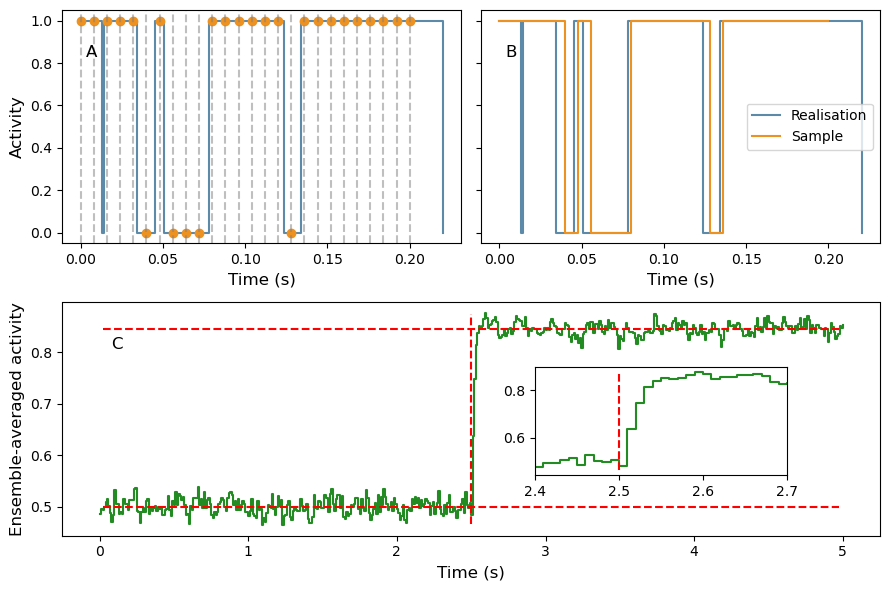

In [7]:
# preparation
fig = plt.figure(figsize=(9,6))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,:1])
ax2 = plt.subplot(gs[0,1:],sharey=ax1)
ax3 = plt.subplot(gs[1,:])

# inset for the third plot
left, bottom, width, height = [0.6, 0.20, 0.28, 0.18]
axx = fig.add_axes([left, bottom, width, height])

# parameters for showing how sampling works
Ns = 1
tf = 0.2
tc = tf + 1
st = tf/25

ensemble, all_tau = mwc_simulator(Ns,tf,tc)
all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)

# show actual realisation and the sampling comb
for n in range(Ns):
    ax1.step(np.cumsum(all_tau[n]),ensemble[n],where='post',color=my_blue)
    ax1.plot(t_grid,all_samples[n],'o',color=my_yellow)
    
for t in t_grid:
    ax1.axvline(x=t,ls='--',color='grey',alpha=0.5)

# show the resulting sample    
ax2.step(np.cumsum(all_tau[0]),ensemble[0],where='post',color=my_blue,label='Realisation')
ax2.step(t_grid,all_samples[0],where='post',color=my_yellow,label='Sample')

ax2.legend(fontsize=10)
plt.setp(ax2.get_yticklabels(), visible=False)

# show a representative time series of the average
Ns = 1000
tf = 5
tc = 2.5
c0 = 100
cf = 70
st = 0.01

ensemble, all_tau = mwc_simulator(Ns,tf,tc,cf=cf)
all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)

# for n in range(0,Ns,100):
#     ax3.step(np.cumsum(all_tau[n]),ensemble[n],where='post',color='grey',alpha=0.1)
    
ax3.step(t_grid,np.mean(all_samples,axis=0),where='post',color=my_green)
ax3.axvline(x=tc,ymin=0.05,ymax=0.95,ls='--',color='r')
ax3.axhline(y=pA(c0,6),xmin=0.05,xmax=0.95,ls='--',color='r')
ax3.axhline(y=pA(cf,6),xmin=0.05,xmax=0.95,ls='--',color='r')

axx.step(t_grid,np.mean(all_samples,axis=0),where='post',color=my_green)
axx.axvline(x=tc,ymin=0.05,ymax=0.95,ls='--',color='r')
axx.set_xlim(tc-0.1,tc+0.2)

# further formatting
letter_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel('Time (s)',size=12)
    ax.text(0.06,0.8,letter_list[i],size=12,transform = ax.transAxes)
    
ax1.set_ylabel('Activity',size=12)
ax3.set_ylabel('Ensemble-averaged activity',size=12)

plt.tight_layout()
#fig.savefig('Figures/sampling.pdf')
plt.show()

### Response kernel & DRC

In [5]:
def drc(Ns,tf,tc,st,c_arr,c0=100,N=6):
    '''
    Finds the dose-response curve for the MWC model.
    
    Parameters
    ----------
    Ns: int
        number of realisations
    tf: float
        final time of the simulations in s
    tc: float
        time in s at which the concentration is changed
    st: float
        sampling period in s
    c_arr: ndarray
        array of final concentrations in microM
    c0: float
        initial concentration. Default is 100 microM
    N: float
        number of receptors per MWC cluster
    
    Returns
    ----------
    delta_a: ndarray
        ensemble-averaged response, defined as the difference between the pre- 
        and post-stimulus activity. Of same length as c_arr.
    var_delta_a: ndarray
        variance of the response, assuming that the pre- and post-stimulus activity
        are uncorrelated in time
        
    '''
    delta_a = np.zeros(c_arr.size,dtype='float64')
    # var_delta_a = np.zeros_like(delta_a)
    
    for k,cf in enumerate(c_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = mwc_simulator(Ns,tf,tc,c0=c0,cf=cf,N=N)
        all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)
        
        # compute average activity and take pre- and post-stimulus activity
        av_act = np.mean(all_samples,axis=0)
        # var_act = np.var(all_samples,axis=0)
        
        a_pre = av_act[int(tc//st) - 1]
        a_post = av_act[-1]
        delta_a[k] = a_post - a_pre # response
        
        # # calculate the ensemble variances
        # var_pre = var_act[int(tc//st) - 1]
        # var_post = var_act[-1]
        # var_delta_a[k] = var_pre + var_post # assume a_pre and a_post are independent
        
    return delta_a

# Hill function used for fitting
def hill_function(c,nH,d_max):
    c0 = 100
    return 2*d_max*(c**nH/(c0**nH + c**nH) - 0.5)

In [9]:
Ns = 10**3
tf = 4
tc = 2
st = 0.1
c_arr = np.array([70,80,100,120])

%timeit drc(Ns,tf,tc,st,c_arr)

479 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


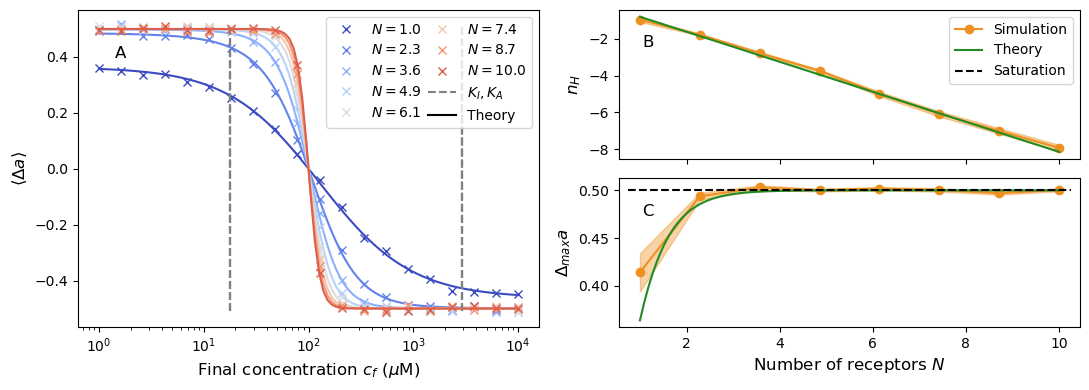

In [14]:
# preparation
fig_drc_mwc = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,:1])
ax2 = plt.subplot(gs[0,1:])
ax3 = plt.subplot(gs[1,1:],sharex=ax2)

# parameters
#N_arr = np.arange(1,12,2)
N_arr = np.linspace(1,10,8)
Ns = 5000
tf = 4
tc = 2
st = 0.1
c_arr = np.logspace(0.,4.,20)
c_arr_plt = np.logspace(0.,4.,100)

hill_parms = np.zeros((2,N_arr.size),dtype='float64') # to store results
hill_std = np.zeros_like(hill_parms)
handles = []

for n,N in enumerate(N_arr):
    # obtain drc
    delta_a = drc(Ns,tf,tc,st,c_arr,N=N)
    theoretical_drc = pA(c_arr_plt,N) - pA(100,N)
    
    # fit Hill function
    hill_popt, hill_pcov = curve_fit(hill_function,c_arr,delta_a,bounds=([-np.inf,0],[0,np.inf]))
    hill_parms[:,n] = hill_popt
    hill_std[:,n] = [np.sqrt(hill_pcov[i,i]) for i in range(2)] 
    
    # results
    color = colormap(n/N_arr.size)
    
    # theoretical result
    ax1.semilogx(c_arr,delta_a,'x',label=f'$N={N}$',color=color)    
    ax1.semilogx(c_arr_plt,theoretical_drc,color=color)
    ax1.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ki
    ax1.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ka
    
    handles.append(Line2D([],[],color=color,marker='x',linestyle='None',label=f'$N={np.round(N,1)}$'))
    
    # Hill function
    # ax2.semilogx(c_arr,delta_a,'x',color=color)
    # ax2.semilogx(c_arr_plt,hill_function(c_arr_plt,*hill_popt),'--',color=color)
    # ax2.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ki
    # ax2.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ka
    
# formatting
handles.append(Line2D([], [], color='grey', linestyle='--', label=r'$K_I,K_A$'))
handles.append(Line2D([], [], color='k', label=r'Theory'))

ax1.legend(handles=handles,fontsize=10,ncol=2,columnspacing=0.5)
ax1.set_ylabel(r'$\langle \Delta a \rangle$',size=12)
ax1.set_xlabel(r'Final concentration $c_f$ ($\mu$M)',size=12)
ax1.text(0.08,0.85,'A',size=12,transform = ax1.transAxes)

# ax2.set_xlabel(r'Final concentration ($\mu$M)',size=12)
# ax2.set_ylabel(r'$\langle \Delta a \rangle$',size=12)

# fitting parameters
th_nH = N_arr*100*(18-2900)/((18+100)*(2900+100)) # theoretical result

ax2.plot(N_arr,hill_parms[0],'-o',label='Simulation',color=my_yellow)
ax2.fill_between(N_arr,hill_parms[0]-hill_std[0],hill_parms[0]+hill_std[0],color=my_yellow,alpha=0.4)
ax2.plot(N_arr,th_nH,label='Theory',color=my_green)
ax2.set_ylabel(r'$n_H$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

# legend
handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label=f'Simulation'))
handles.append(Line2D([], [], color=my_green, label=r'Theory'))
handles.append(Line2D([], [], color='k', linestyle='--', label=r'Saturation'))
ax2.legend(handles=handles,fontsize=10)

N_arr_plt = np.linspace(N_arr[0],N_arr[-1],100) # for plotting a smooth curve
th_dmax_a = (1/(1 + ((1 + 100/2900)/(1 + 100/18))**N_arr_plt) - 0.5) # theoretical

ax3.plot(N_arr,hill_parms[1],'-o',color=my_yellow)
ax3.fill_between(N_arr,hill_parms[1]-hill_std[1],hill_parms[1]+hill_std[1],color=my_yellow,alpha=0.4)
ax3.plot(N_arr_plt,th_dmax_a,color=my_green)
ax3.axhline(y=0.5,xmin=0.02,xmax=0.98,ls='--',color='k',label='Saturation')
ax3.set_ylabel(r'$\Delta_{max} a$',size=12)
ax3.set_xlabel(r'Number of receptors $N$',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [15]:
fig_drc_mwc.savefig('Figures/drc_mwc.pdf')

### Response kernel

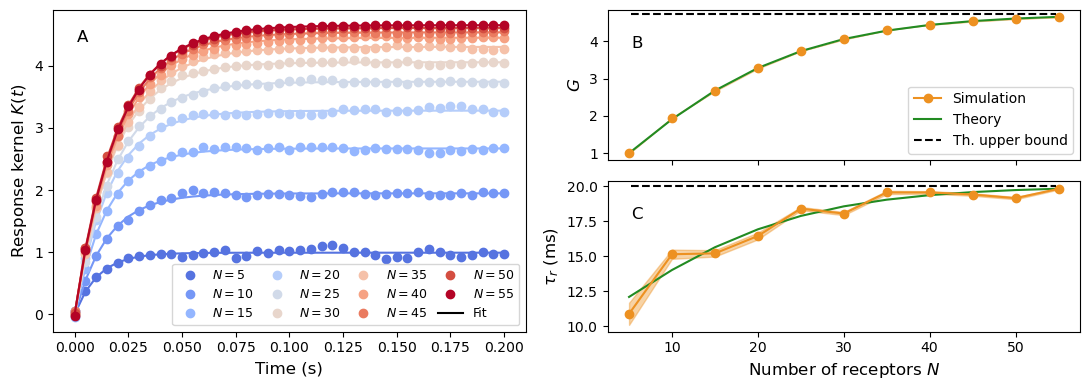

In [16]:
# nonadaptive response kernel
def rk_star(t,G,tau_r):
    return G*(1-np.exp(-t/tau_r))

# preparation
fig_rk_mwc_na = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

N_arr = np.arange(5,56,5)
Ns = 10**4
tf = 3.2
tc = 3.
st = 0.005
k_act = 50
c0 = 100
cf = 90

rk_parms = np.zeros((2,N_arr.size),dtype='float64')
rk_sds = np.zeros_like(rk_parms)
handles = []

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    ensemble, all_tau = mwc_simulator(Ns,tf,tc,c0=c0,cf=cf,k_act=k_act,N=N)
    all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)
    
    # find response kernel
    av_act = np.mean(all_samples,axis=0)
    response = (av_act[t_grid >= tc] - 0.5)/np.log(c0/cf)
    time_s = t_grid[t_grid >= tc] - tc
    
    # fitting
    popt, pcov = curve_fit(rk_star,time_s,response)
    rk_parms[:,n] = popt
    rk_sds[:,n] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    ax1.plot(time_s,response,'o',color=colormap((n+1)/N_arr.size))
    ax1.plot(time_s,rk_star(time_s,*popt),color=colormap((n+1)/N_arr.size))
    handles.append(Line2D([],[],color=colormap((n+1)/N_arr.size),marker='o',linestyle='None',label=f'$N={N}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='lower right',fontsize=9,ncol=4,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Response kernel $K(t)$',size=12) 
ax1.text(0.05,0.9,'A',size=12,transform = ax1.transAxes)

ax2.plot(N_arr,(pA(cf,N_arr)-0.5)/np.log(c0/cf),color=my_green,label='Theory')
ax2.plot(N_arr,rk_parms[0,:],'o',color=my_yellow,label='Simulation')
ax2.fill_between(N_arr,rk_parms[0,:]-rk_sds[0,:],rk_parms[0,:]+rk_sds[0,:],color=my_yellow,alpha=0.4)
ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color='k')

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label='Simulation'))
handles.append(Line2D([],[],color=my_green,label=f'Theory'))
handles.append(Line2D([],[],color='k',linestyle='--',label='Th. upper bound'))

ax2.legend(handles=handles,loc='lower right',fontsize=10)
ax2.set_ylabel(r'$G$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(N_arr,rk_parms[1,:]*1000,'-o',color=my_yellow)
ax3.fill_between(N_arr,(rk_parms[1,:]-rk_sds[1,:])*1000,(rk_parms[1,:]+rk_sds[1,:])*1000,color=my_yellow,alpha=0.4)
ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color='k')

ax3.set_xlabel(r'Number of receptors $N$',size=12)
ax3.set_ylabel(r'$\tau_r$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [17]:
# fig_rk_mwc_na.savefig('Figures/rk_mwc_na.pdf')

### Noise kernel

In [6]:
@numba.jit(nopython=True)
def cell_activity(Ns,Nc,tf,tc,st,N=6,cf=90):
    '''
    Finds an ensemble of single-cell activities, i.e., activities averaged over the cell's clusters.
    Runs on Numba's nopython mode.

    Parameters
    ----------
    Ns: int
        number of samples, i.e., the number of cells in the ensemble
    Nc: int
        number of clusters per cell
    tf: float
        final time of the underlying Gillepsie simulation
    tc: float
        time at which the concentration is changed
    st: float
        sampling time period
    N: float, optional
        number of receptors per cluster. By default 6
    cf: float, optional
        final concentration. Default is 90 microM

    Returns
    ----------
    all_cell_act: ndarray
        time-sampled traces of the activity for each cell. Shape is (Ns,int(tf/st) + 1)
    t_grid: ndarray
        times at which the time series are sampled, length int(tf/st) + 1
       
    '''
   
    # array to save result
    all_cell_act = np.zeros((Ns,int(tf/st) + 1),dtype='float64')
   
    for s in range(Ns):
        # obtain a single-cell realisation
        ensemble, all_tau = mwc_simulator(Nc,tf,tc,cf=cf,N=N)
        all_samples, t_grid = sampler(ensemble,all_tau,Nc,tf,st)
        all_cell_act[s,:] = np.sum(all_samples,axis=0)/Nc # average over the cell's clusters
   
    return all_cell_act, t_grid

def autocorr(ensemble,t_grid,co):
    '''
    Computes the autocorrelation of an ensemble over time.
    
    Parameters
    ----------
    ensemble: ndarray
        contains samples of the realisations over time
    t_grid: ndarray
        regularly spaced times at which the realisations have been sampled
    co: int
        cut-off point where time is reset to zero to ensure equilibrium
        
    Returns
    ----------
    auto_corr: ndarray
        autocorrelation over time
    time_s: ndarray
        time shifted such that time is zero at the cut-off point
        
    '''
    # obtain relevant ensemble averages
    av_prod = np.mean(ensemble[:,co:].T*ensemble[:,co].T,axis=1)
    prod_av = np.mean(ensemble[:,co:],axis=0)*np.mean(ensemble[:,co])
   
    # shift time
    time_s = t_grid[co:]-t_grid[co]
   
    # return autocorrelation
    return av_prod - prod_av, time_s

/tmp/ipykernel_4895/4154529116.py:3: RuntimeWarning: overflow encountered in exp
  return sigma_n**2*np.exp(-np.abs(t)/tau_n)


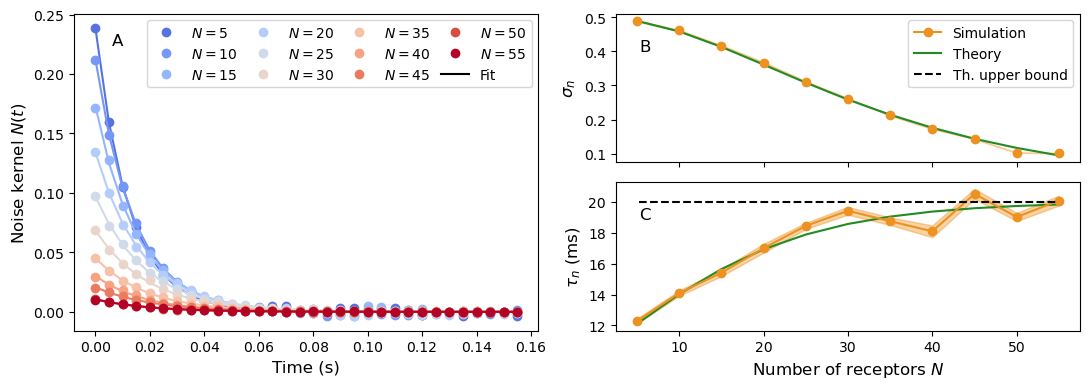

In [30]:
# noise kernel
def nk(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-np.abs(t)/tau_n)

# preparation
fig_nk_mwc_na = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

N_arr = np.arange(5,56,5)
Ns = 10**4
Nc = 1
tf = 3.
tc = 0.0
st = 0.005
co = int(0.95*tf/st)
cf = 90

nk_parms = np.zeros((2,N_arr.size),dtype='float64')
nk_sds = np.zeros_like(nk_parms)

handles = []

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    cell_ensemble, t_grid = cell_activity(Ns,Nc,tf,tc,st,N=N,cf=cf)
    auto_corr, time_s = autocorr(cell_ensemble,t_grid,co)
    
    # fitting
    popt, pcov = curve_fit(nk,time_s,auto_corr)
    nk_parms[:,n] = popt
    nk_sds[:,n] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    # show results
    ax1.plot(time_s,auto_corr,'o',color=colormap((n+1)/N_arr.size))
    ax1.plot(time_s,nk(time_s,*popt),color=colormap((n+1)/N_arr.size))
    handles.append(Line2D([],[],color=colormap((n+1)/N_arr.size),marker='o',linestyle='None',label=f'$N={N}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='upper right',fontsize=10,ncol=4,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Noise kernel $N(t)$',size=12) 
ax1.text(0.08,0.9,'A',size=12,transform = ax1.transAxes)

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label='Simulation'))
handles.append(Line2D([],[],color=my_green,label=f'Theory'))
handles.append(Line2D([],[],color='k',linestyle='--',label='Th. upper bound'))

ax2.plot(N_arr,np.sqrt(pA(cf,N_arr)*(1-pA(cf,N_arr))),color=my_green,label='Theory')
ax2.plot(N_arr,nk_parms[0,:],'o',color=my_yellow,label='Simulation')
ax2.fill_between(N_arr,nk_parms[0,:]-nk_sds[0,:],nk_parms[0,:]+nk_sds[0,:],color=my_yellow,alpha=0.4)
#ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax2.legend(loc='upper right',handles=handles,fontsize=10)
ax2.set_ylabel(r'$\sigma_n$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(N_arr,nk_parms[1,:]*1000,'-o',color=my_yellow)
ax3.fill_between(N_arr,(nk_parms[1,:]-nk_sds[1,:])*1000,(nk_parms[1,:]+nk_sds[1,:])*1000,color=my_yellow,alpha=0.4)
ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color='k')

ax3.set_xlabel(r'Number of receptors $N$',size=12)
ax3.set_ylabel(r'$\tau_n$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [31]:
# fig_nk_mwc_na.savefig('Figures/nk_mwc_na.pdf')

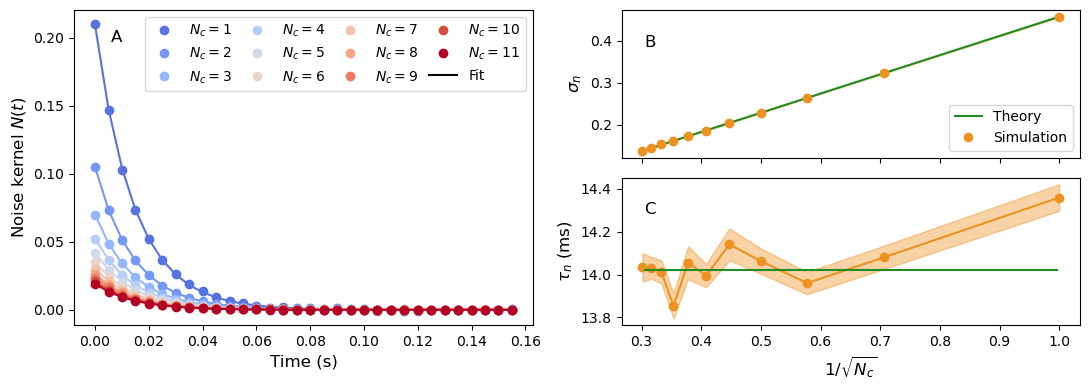

In [32]:
# preparation
fig = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

Nc_arr = np.arange(1,12,1)
Ns = 10**5
N = 10
tf = 3.
tc = 0.0
st = 0.005
co = int(0.95*tf/st)
cf = 90

Nc_nk_parms = np.zeros((2,Nc_arr.size),dtype='float64')
Nc_nk_sds = np.zeros_like(Nc_nk_parms)

handles = []

for n,Nc in enumerate(Nc_arr):
    # obtain ensemble and sample
    cell_ensemble, t_grid = cell_activity(Ns,Nc,tf,tc,st,N=N,cf=cf)
    auto_corr, time_s = autocorr(cell_ensemble,t_grid,co)
    
    # fitting
    popt, pcov = curve_fit(nk,time_s,auto_corr)
    Nc_nk_parms[:,n] = popt
    Nc_nk_sds[:,n] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    # show results
    ax1.plot(time_s,auto_corr,'o',color=colormap((n+1)/Nc_arr.size))
    ax1.plot(time_s,nk(time_s,*popt),color=colormap((n+1)/Nc_arr.size),label=f'$N_c={Nc}$')
    handles.append(Line2D([],[],color=colormap((n+1)/N_arr.size),marker='o',linestyle='None',label=f'$N_c={Nc}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='upper right',fontsize=10,ncol=4,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Noise kernel $N(t)$',size=12) 
ax1.text(0.08,0.9,'A',size=12,transform = ax1.transAxes)

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label='Simulation'))
handles.append(Line2D([],[],color=my_green,label=f'Theory'))

ax2.plot(1/np.sqrt(Nc_arr),np.sqrt(pA(cf,N)*(1-pA(cf,N))/Nc_arr),color=my_green,label='Theory')
ax2.plot(1/np.sqrt(Nc_arr),Nc_nk_parms[0,:],'o',color=my_yellow,label='Simulation')
ax2.fill_between(1/np.sqrt(Nc_arr),Nc_nk_parms[0,:]-Nc_nk_sds[0,:],Nc_nk_parms[0,:]+Nc_nk_sds[0,:],color=my_yellow,alpha=0.4)
#ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax2.legend(loc='lower right',fontsize=10)
ax2.set_ylabel(r'$\sigma_n$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(1/np.sqrt(Nc_arr),Nc_nk_parms[1,:]*1000,'-o',color=my_yellow)
ax3.fill_between(1/np.sqrt(Nc_arr),(Nc_nk_parms[1,:]-Nc_nk_sds[1,:])*1000,(Nc_nk_parms[1,:]+Nc_nk_sds[1,:])*1000,color=my_yellow,alpha=0.4)
ax3.axhline(y=pA(cf,N)/k_act*1000,xmin=0.05,xmax=0.95,color=my_green)

ax3.set_xlabel(r'$1/\sqrt{N_c}$',size=12)
ax3.set_ylabel(r'$\tau_n$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [33]:
# fig.savefig('Figures/nk_mwc_na_SI.pdf')

## Adaptive MWC

### Main functions

In [7]:
@numba.jit(nopython=True)
def multi_dim_sampler(ensemble,all_tau,Ns,tf,st):
    '''
    Samples the time series of an ensemble defined by waiting times at regular time points.
    The ensemble consists of state vectors of length larger than 1. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    ensemble: typed List
        contains Ns realisations over time
    all_tau: typed List
        contains the waiting times for each realisation
    Ns: int
        number of realisations
    tf: float
        final time of the simulation of the ensemble
    st: float
        sampling time
    
    Returns
    ----------
    all_samples: ndarray
        contains the sampled version of each realisation from 0 to tf. Has shape (Ns,int(tf/st) + 1,D),
        where the state is described by D variables
    t_grid: ndarray
        regularly spaced grid of time points from 0 to tf at which the samples have been taken

    '''
    # arrays to save results
    D = len(ensemble[0][0])
    all_samples = np.zeros((Ns,int(tf/st)+1,D),dtype='float64')
        
    t_grid = np.linspace(0,tf,int(tf/st)+1)
    
    # sample each realisation
    for s in range(Ns):
        # time of the realisation
        time_r = np.cumsum(all_tau[s])
        
        for n,t_s in enumerate(t_grid):
            # find first instance where the sampling time is below the waiting time
            idx = np.argmax(t_s < time_r)
            
            # store the value of the realisation before the sampling time crosses the event time
            all_samples[s,n] = ensemble[s][idx-1]
            
    return all_samples, t_grid

In [8]:
# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob,size=1):
    '''
    Numba-analog of np.random.choice().
    
    Parameters
    ----------
    outcomes: ndarray
        array of possible values of the random variable of interest
    prob: ndarray
        array of probabilities corresponding to each outcome
    size: int
        size of the sample. Default is 1
    
    Returns
    ----------
    sample: float
        a sample drawn from outcomes given the probabilities in prob
    '''
    
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(size))]

In [9]:
@numba.jit(nopython=True)
def adaptive_mwc_simulator(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900,
                          dfm=-2,kR=0.075,kB=0.15):
    '''
    Simulates a kinetic, adaptive MWC model using Gillespie's algorithm. Runs in Numba's
    nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of samples
    tf: float
        final time of the simulation. By default, unit is s
    tc: float
        time at which the concentration changes
    k_act: float, optional
        sets time scale of (de)activation kinetics. Default is 50 per s
    c0: float, optional
        baseline concentration in microM. Default is 100 microM
    cf: float, optional
        concentration after the step change in microM. Default is 90 microM
    N: float, optional
        number of receptors per MWC cluster. Default is 6
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively
    dfm: float
        free-energy cost of an additional methyl group. Default is -2 kT
    kR, kB: float
        methylation and demethylation rate, respectively. Defaults are 0.075 
        and 0.15 per s, respectively
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns activities and Ns methylation levels
        Note: the methylation level is an integer between 0 and 4*N
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    
    '''
    # other methylation parameters
    m0 = N/2 # baseline 
    mMax = 4*N # maximum 
    
    # objects to store results
    ensemble = List() # use Numba lists; nested list will be deprecated
    all_tau = List()
    
    rates = np.zeros(2,dtype='float64')
    events = np.zeros((2,2),dtype='float64')
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialise each realisation
        tau = np.array([0.])
        am = np.array([[0.,0.]])
        stack_aux = np.array([[0.,0.]]) # needed later on for stacking
        
        am[0,0] = biased_choice(np.array([0.,1.]),np.array([kB/(kR+kB),kR/(kR+kB)]))[0]
        am[0,1] = mMax/3
        
        # initialise concentration-dependent free energy and time
        Fc = N*np.log((1+c0/Ki)/(1+c0/Ka))
        time = 0
        switch_bool = False # to keep track of concentration switch
        
        # run until the final time
        while time <= tf:
            # calculate free-energy difference
            F = Fc + dfm*(am[-1,1] - m0)

            # set methylation booleans
            m_ceiling = am[-1,1] < mMax
            m_floor = am[-1,1] > 0.
            
            # set rates and possible events
            if am[-1,0] == 0.: # inactive cluster
                rates[0] = k_act # activation
                events[0] = np.array([1.,0.])

                rates[1] = kR*m_ceiling # methylation
                events[1] = np.array([0.,1.])

            else: # active cluster
                rates[0] = k_act*np.exp(F) # deactivation
                events[0] = np.array([-1.,0.])

                rates[1] = kB*m_floor # demethylation
                events[1] = np.array([0.,-1.])

            # determine waiting time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # condition on which to change concentration
            if time >= tc and not switch_bool:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update free energy
                Fc = N*np.log((1+cf/Ki)/(1+cf/Ka))
                F = Fc + dfm*(am[-1,1] - m0)

                # update rates for deactivation (only one that changes)
                if am[-1,0] == 1.:
                    rates[0] = k_act*np.exp(F)

                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates) # reset time to before the transgression

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                stack_aux[0,0] = am[-1,0] + events[e_idx,0] # for stacking later on; dumb Numba way
                stack_aux[0,1] = am[-1,1] + events[e_idx,1]
                
                # update time and state and the switch boolean
                tau = np.append(tau,advance-np.log(u)/np.sum(rates))
                am = np.vstack((am,stack_aux))
                switch_bool = True

            else: # most cases
                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                
                stack_aux[0,0] = am[-1,0] + events[e_idx,0] # for stacking later on; dumb Numba way
                stack_aux[0,1] = am[-1,1] + events[e_idx,1]
                
                # save results
                tau = np.append(tau,-np.log(u)/np.sum(rates))
                am = np.vstack((am,stack_aux))
    
        # store the realisation
        all_tau.append(tau)
        ensemble.append(am)
    
    return ensemble, all_tau

def pA_m(c,N,m,c0=100,Ki=18,Ka=2900,dfm=-2):
    '''
    Returns the probability that an adaptive MWC cluster is active at equilibrium.
    
    Parameters
    ----------
    c: ndarray
        concentration in microM
    N: ndarray
        number of receptors per cluster
    m: ndarray
        number of methyl groups bound
    c0: float
        baseline concentration in microM. Default is 100 microM
    Ki, Ka: float
        dissocation constants of the inactive and active state, respectively.
        Defaults are 18 and 2900 microM, respectively
    dfm: float
        free energy due to binding one methyl group. Default is -2kBT
        
    Returns
    ----------
    pA_m: ndarray
        probability that the cluster is active
        
    '''
    m0 = N/2 # baseline methylation
    F = N*np.log((1+c/Ki)/(1+c/Ka)) + dfm*(m-m0)
    return 1/(1+np.exp(F))

In [37]:
Ns = 10**1
tf = 20
tc = 10
cf = 70

%timeit adaptive_mwc_simulator(Ns,tf,tc,cf=cf)

26.4 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Perfect adaptation

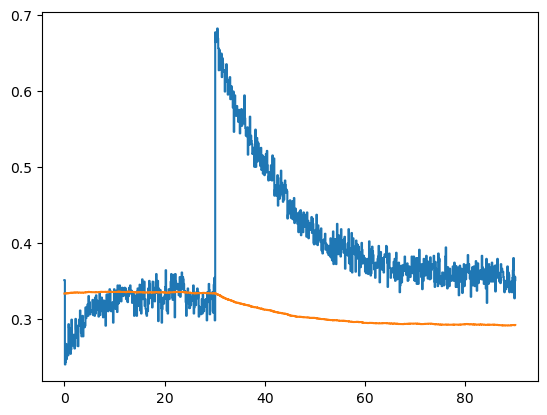

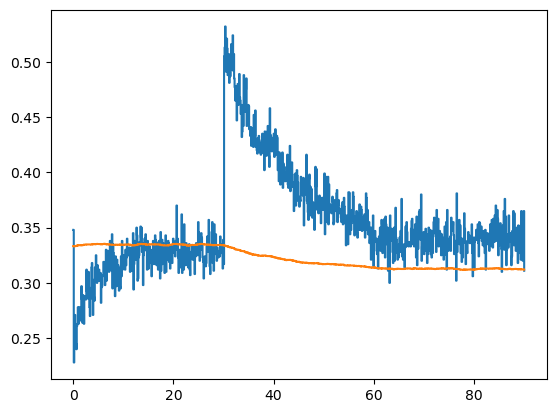

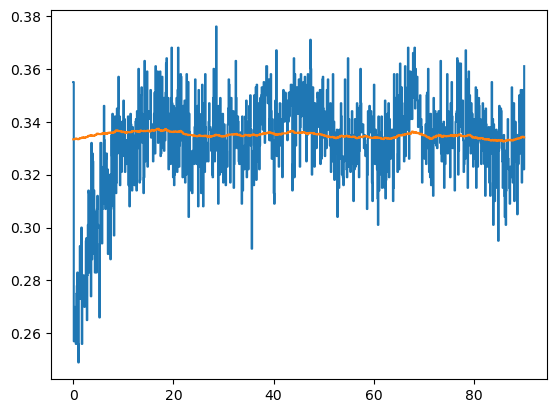

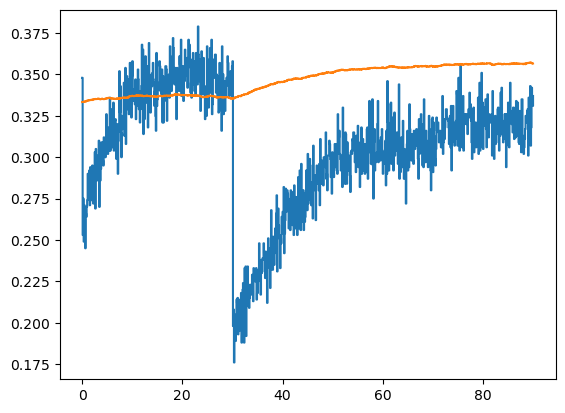

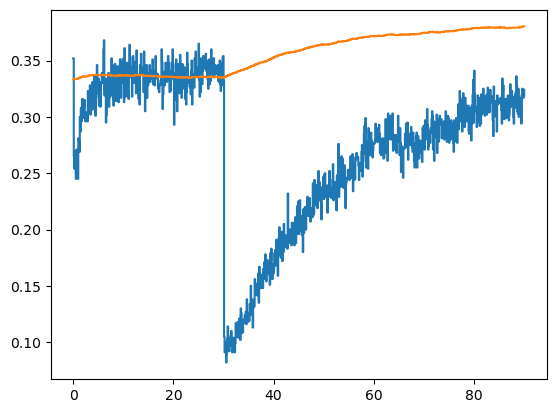

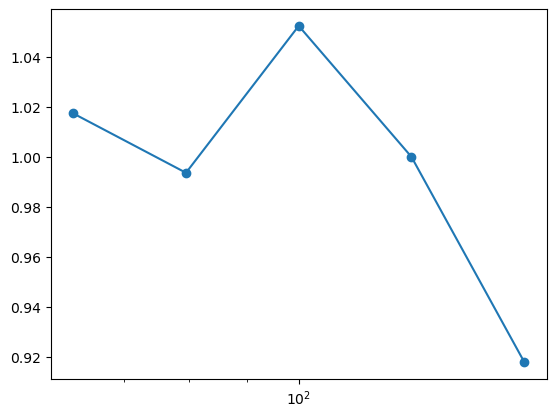

In [325]:
# parameters
Ns = 1000
tf = 100
tc = 35
st = 0.1

cf_arr = np.logspace(1.8,2.2,5)
precision = np.zeros_like(cf_arr,dtype='float64')

for k,cf in enumerate(cf_arr):
    # obtain an ensemble
    ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,cf=cf)
    all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)
    
    # compute the adaptation precision
    precision[k] = np.mean(all_samples,axis=0)[-1,0]/np.mean(all_samples,axis=0)[int(tc//st)-1,0]

    # show the ensemble average as a check
    plt.step(t_grid,np.mean(all_samples,axis=0)[:,0],where='post')
    plt.step(t_grid,np.mean(all_samples,axis=0)[:,1]/24,where='post')
    plt.show()

plt.semilogx(cf_arr,precision,'-o')
plt.show()

### Response kernel

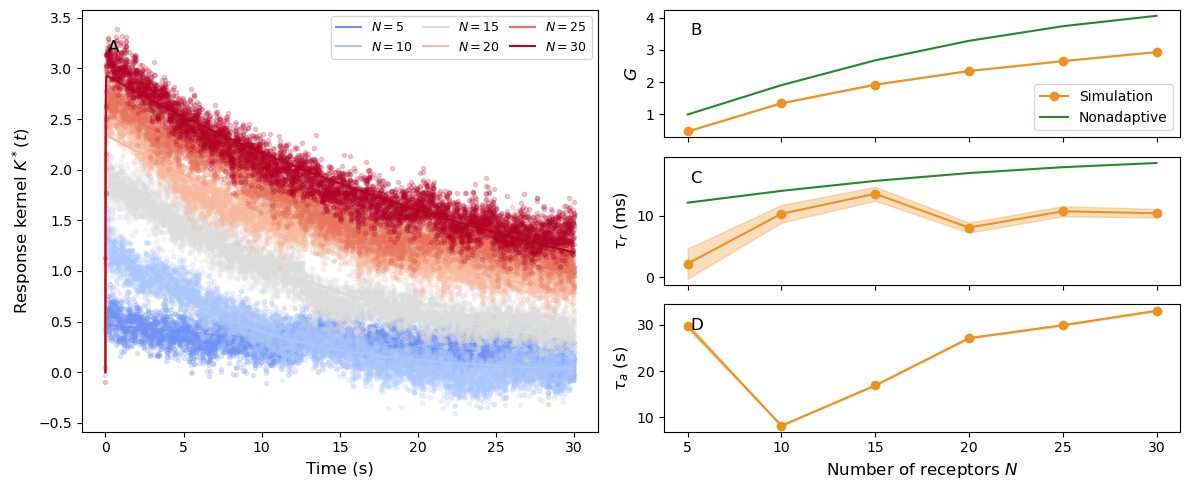

In [38]:
# nonadaptive response kernel
def rk(t,G,tau_r,tau_a):
    return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)

# fitting function for methylation level
def mk(t,mB,tau_m):
    return mB*np.exp(-t/tau_m)

# preparation
fig = plt.figure(figsize=(12,5))

# create subplots
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)
ax4 = plt.subplot(gs[2,1],sharex=ax2)

N_arr = np.arange(5,31,5)
Ns = 1000
tf = 60
tc = 30
st = 0.005
k_act = 50
c0 = 100
cf = 90

# arrays to store results
rk_adap_parms = np.zeros((3,N_arr.size),dtype='float64')
rk_adap_sds = np.zeros_like(rk_adap_parms)

mk_parms = np.zeros((2,N_arr.size),dtype='float64')
mk_sds = np.zeros_like(mk_parms)

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,N=N,c0=c0,cf=cf,k_act=k_act)
    all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)
    
    # find response kernel
    av_act = np.mean(all_samples[:,:,0],axis=0)
    response = (av_act[t_grid >= tc] - av_act[int(tc/st)-1])/np.log(c0/cf)
    time_s = t_grid[t_grid >= tc] - tc
    
    # fitting
    rk_popt, rk_pcov = curve_fit(rk,time_s,response,bounds=(0,np.inf))
    rk_adap_parms[:,n] = rk_popt
    rk_adap_sds[:,n] = [np.sqrt(rk_pcov[i,i]) for i in range(3)]
    
    # show results
    ax1.plot(time_s,response,'.',alpha=0.2,color=colormap((n+1)/N_arr.size))
    ax1.plot(time_s,rk(time_s,*rk_popt),color=colormap((n+1)/N_arr.size),label=f'$N={N}$')
    
    # characterise how methylation responds
    av_meth = np.mean(all_samples[:,:,1],axis=0)/(4*N)
    meth_response = av_meth[t_grid >= tc] - av_meth[-1]
    mk_popt, mk_pcov = curve_fit(mk,time_s,meth_response,bounds=(0,np.inf))
    mk_parms[:,n] = mk_popt
    mk_sds[:,n] = [np.sqrt(mk_pcov[i,i]) for i in range(2)]
    
# formatting
ax1.legend(loc='upper right',fontsize=9,ncol=3,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Response kernel $K^*(t)$',size=12) 
ax1.text(0.05,0.9,'A',size=12,transform = ax1.transAxes)

# convert the response time to units of ms
rk_adap_parms[1,:] *= 1000
rk_adap_sds[1,:] *= 1000

# plot the fitting parameters
letter_list = ['B','C','D']
for i,ax in enumerate((ax2,ax3,ax4)):
    ax.plot(N_arr,rk_adap_parms[i,:],'-o',color=my_yellow,label='Simulation')
    ax.fill_between(N_arr,rk_adap_parms[i,:]-rk_adap_sds[i,:],rk_adap_parms[i,:]+rk_adap_sds[i,:],color=my_yellow,alpha=0.3)
    ax.text(0.05,0.8,letter_list[i],size=12,transform = ax.transAxes) # formatting

# formatting and theoretical results
ax2.plot(N_arr,(pA(cf,N_arr)-0.5)/np.log(c0/cf),color=my_green,label='Non-adaptive') # theoretical
#ax2.axhline(y=(2/3)/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax2.legend(loc='lower right',fontsize=10)
ax2.set_ylabel(r'$G$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green) # theoretical
#ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax3.set_ylabel(r'$\tau_r$ (ms)',size=12)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4.set_xlabel(r'Number of receptors $N$',size=12)
ax4.set_ylabel(r'$\tau_a$ (s)',size=12)

plt.tight_layout()

plt.show()

In [56]:
m0 = N_arr/2 # baseline methylation
#F = N*np.log((1+c/Ki)/(1+c/Ka)) + dfm*(m-m0)
cf = 1
m = m_inf(cf,N_arr)

print('spin part',N_arr*np.log((1+cf/18)/(1+cf/2900)))
print('meth part',-2*(m-m0))
print('sum',N_arr*np.log((1+cf/18)/(1+cf/2900))-2*(m-m0))
print('prob',1/(1+np.exp(N_arr*np.log((1+cf/18)/(1+cf/2900))-2*(m-m0))))

spin part [0.26861227 0.53722453 0.8058368  1.07444906 1.34306133 1.61167359]
meth part [ 0.06472107 -0.2038912  -0.47250346 -0.74111573 -1.00972799 -1.27834026]
sum [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
prob [0.41742979 0.41742979 0.41742979 0.41742979 0.41742979 0.41742979]


In [46]:
pA_m(cf,N_arr,m_inf(cf,N_arr))

array([0.41742979, 0.41742979, 0.41742979, 0.41742979, 0.41742979,
       0.41742979])

In [47]:
m_inf(cf,N_arr)

array([ 6.73632538, 13.63931743, 20.54230947, 27.44530152, 34.34829357,
       41.25128562])

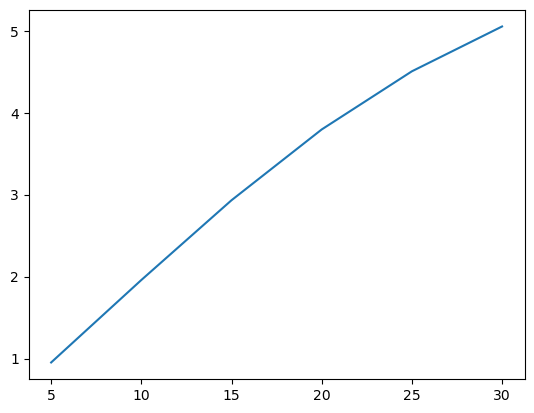

In [69]:
def m_inf(c,N,Ki=18,Ka=2900,dfm=-2):
    m0 = N/2
    return m0 + (1/dfm)*np.log(2/(((1+c/Ki)/(1+c/Ka))**N))

plt.plot(N_arr,(pA_m(90,N_arr,m_inf(100,N_arr))-1/3)/np.log(100/90))
plt.show()

In [73]:
(pA_m(90,N_arr,m_inf(100,N_arr))-1/3)/np.log(100/90)
pA_m(90,N_arr,m_inf(100,100))-1/3

array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667])

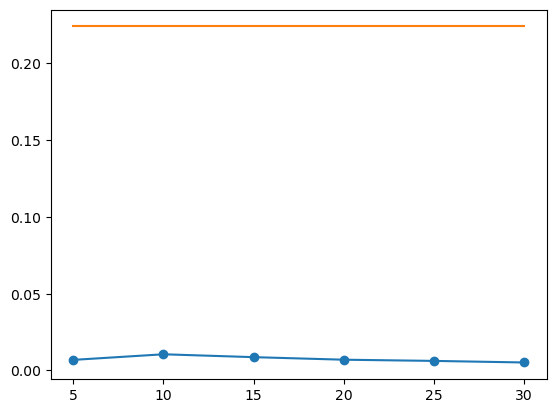

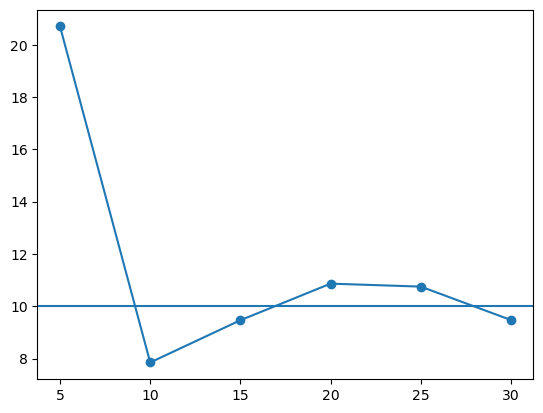

In [62]:
plt.plot(N_arr,mk_parms[0,:],'-o')
plt.plot(N_arr,(m_inf(100,N_arr)-m_inf(cf,N_arr))/(4*N_arr))
plt.show()

plt.plot(N_arr,mk_parms[1,:],'-o')
plt.axhline(y=0.5*((1/0.15) + (1/0.075)))
plt.show()

In [346]:
Ns = 1000
tf = 100
tc = 35
cf = 70
st = 0.01

ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,cf=cf)
all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)

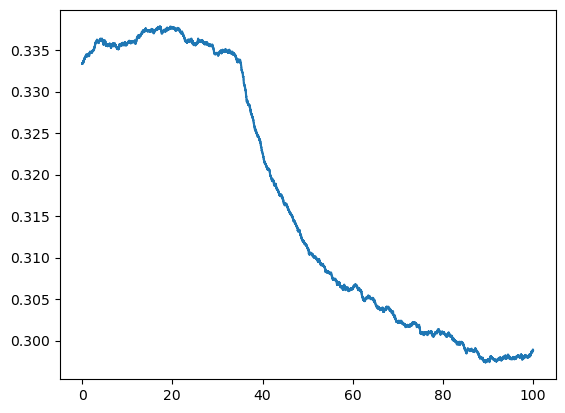

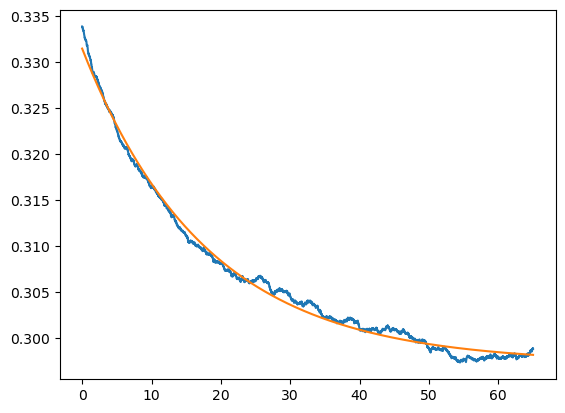

In [351]:
#plt.step(t_grid,np.mean(all_samples,axis=0)[:,0],where='post')
plt.step(t_grid,np.mean(all_samples,axis=0)[:,1]/24,where='post')
plt.show()

def meth_fit(t,base,scale,tau_m):
    return base + scale*np.exp(-t/tau_m)

av_meth = np.mean(all_samples,axis=0)[:,1]/24

time_s = t_grid[t_grid >= tc] - tc
meth_resp = av_meth[t_grid >= tc]

meth_popt, meth_pcov = curve_fit(meth_fit,time_s,meth_resp)

plt.plot(time_s,meth_resp)
plt.plot(time_s,meth_fit(time_s,*meth_popt))
plt.show()

### Alternative, slower implementations

In [21]:
def list_mwc_simulator(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900,
                          dfm=-2,kR=0.075,kB=0.15):
    '''
    Simulates a kinetic, adaptive MWC model using Gillespie's algorithm. Runs in Numba's
    nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of samples
    tf: float
        final time of the simulation. By default, unit is s
    tc: float
        time at which the concentration changes
    k_act: float, optional
        sets time scale of (de)activation kinetics. Default is 50 per s
    c0: float, optional
        baseline concentration in microM. Default is 100 microM
    cf: float, optional
        concentration after the step change in microM. Default is 90 microM
    N: float, optional
        number of receptors per MWC cluster. Default is 6
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively
    dfm: float
        free-energy cost of an additional methyl group. Default is -2 kT
    kR, kB: float
        methylation and demethylation rate, respectively. Defaults are 0.075 
        and 0.15 per s, respectively
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns activities and Ns methylation levels
        Note: the methylation level is an integer between 0 and 4*N
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    
    '''
    # other methylation parameters
    m0 = N/2 # baseline 
    mMax = 4*N # maximum 
    
    # objects to store results
    ensemble = List() # use Numba lists; nested list will be deprecated
    all_tau = List()
    
    rates = np.zeros(2,dtype='float64')
    events = np.zeros((2,2),dtype='float64')
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialise each realisation
        tau = List()
        am = List()
        a_init = biased_choice(np.array([0.,1.]),np.array([kB/(kR+kB),kR/(kR+kB)]))[0]
        m_init = mMax/3.
        am.append(List([a_init,m_init]))
        
        # initialise concentration-dependent free energy and time
        Fc = N*np.log((1+c0/Ki)/(1+c0/Ka))
        time = 0
        switch_bool = False # to keep track of concentration switch
        
        # run until the final time
        while time <= tf:
            # calculate free-energy difference
            F = Fc + dfm*(am[-1][1] - m0)

            # set methylation booleans
            m_ceiling = am[-1][1] < mMax
            m_floor = am[-1][1] > 0.
            
            # set rates and possible events
            if am[-1][0] == 0.: # inactive cluster
                rates[0] = k_act # activation
                events[0] = np.array([1.,0.])

                rates[1] = kR*m_ceiling # methylation
                events[1] = np.array([0.,1.])

            else: # active cluster
                rates[0] = k_act*np.exp(F) # deactivation
                events[0] = np.array([-1.,0.])

                rates[1] = kB*m_floor # demethylation
                events[1] = np.array([0.,-1.])

            # determine waiting time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # condition on which to change concentration
            if time >= tc and not switch_bool:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update free energy
                Fc = N*np.log((1+cf/Ki)/(1+cf/Ka))
                F = Fc + dfm*(am[-1][1] - m0)

                # update rates for deactivation (only one that changes)
                if am[-1][0] == 1.:
                    rates[0] = k_act*np.exp(F)

                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates) # reset time to before the transgression

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                
                # update time and state and the switch boolean
                tau.append(advance-np.log(u)/np.sum(rates))
                am.append(List([am[-1][0] + events[e_idx,0],am[-1][1] + events[e_idx,1]]))
                switch_bool = True

            else: # most cases
                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))

                # save results
                tau.append(-np.log(u)/np.sum(rates))
                am.append(List([am[-1][0] + events[e_idx,0],am[-1][1] + events[e_idx,1]]))
    
        # store the realisation
        all_tau.append(tau)
        ensemble.append(am)
    
    return ensemble, all_tau

Ns = 10**1
tf = 20
tc = 10
cf = 70

%timeit list_mwc_simulator(Ns,tf,tc)

1.41 s ± 95.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
def numpy_mwc(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900,
                          dfm=-2,kR=0.075,kB=0.15):
    
    # other methylation parameters
    m0 = N/2 # baseline 
    mMax = 4*N # maximum 
    
    # objects to store results
    ensemble = [] # use Numba lists; nested list will be deprecated
    all_tau = []
    
    rates = np.zeros(2,dtype='float64')
    events = np.zeros((2,2),dtype='float64')
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialise each realisation
        tau = np.array([0.])
        am = np.array([[0.,0.]])
        
        am[0,0] = np.random.choice(np.array([0.,1.]),p=np.array([kB/(kR+kB),kR/(kR+kB)]))
        # am[0,1] = biased_choice(meth_outcomes,meth_probs)[0]
        am[0,1] = mMax/3
        
        # initialise concentration-dependent free energy and time
        Fc = N*np.log((1+c0/Ki)/(1+c0/Ka))
        time = 0
        switch_bool = False # to keep track of concentration switch
        
        # run until the final time
        while time <= tf:
            # calculate free-energy difference
            F = Fc + dfm*(am[-1,1] - m0)

            # set methylation booleans
            m_ceiling = am[-1,1] < mMax
            m_floor = am[-1,1] > 0.
            
            # set rates and possible events
            if am[-1,0] == 0.: # inactive cluster
                rates[0] = k_act # activation
                events[0] = np.array([1.,0.])

                rates[1] = kR*m_ceiling # methylation
                events[1] = np.array([0.,1.])

            else: # active cluster
                rates[0] = k_act*np.exp(F) # deactivation
                events[0] = np.array([-1.,0.])

                rates[1] = kB*m_floor # demethylation
                events[1] = np.array([0.,-1.])

            # determine waiting time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # condition on which to change concentration
            if time >= tc and not switch_bool:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update free energy
                Fc = N*np.log((1+cf/Ki)/(1+cf/Ka))
                F = Fc + dfm*(am[-1,1] - m0)

                # update rates for deactivation (only one that changes)
                if am[-1,0] == 1.:
                    rates[0] = k_act*np.exp(F)

                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates) # reset time to before the transgression

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                
                # update time and state and the switch boolean
                tau = np.append(tau,advance-np.log(u)/np.sum(rates))
                am = np.vstack((am,am[-1]+events[e_idx]))
                switch_bool = True

            else: # most cases
                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))

                # save results
                tau = np.append(tau,-np.log(u)/np.sum(rates))
                am = np.vstack((am,am[-1]+events[e_idx])) # numpy way
    
        # store the realisation
        all_tau.append(tau)
        ensemble.append(am)
    
    return ensemble, all_tau

Ns = 10**1
tf = 20
tc = 10
cf = 70

%timeit numpy_mwc(Ns,tf,tc)

748 ms ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Nonadaptive Ising Model

### Main functions

In [10]:
@numba.jit(nopython=True)
def ising_rates(s,J,H,omega0=1,open_boundary=True):
    '''
    Gives the flipping rates for a simple kinetic Ising model.
    
    Parameters
    ----------
    s: 2d array
        lattice of spins
    J: float
        coupling strength in units of kBT
    H: float
        external field strength in units of kBT
    omega0: float, optional
        fundamental flipping frequency. Note that all time is in units of 1/omega0
    open_boundary: bool, optional
        defines the boundary condition. By default, open boundaries are used
        
    Returns
    ----------
    omega: 2d array
        flipping rate of each spin. Has same shape as s and is computed as
        omega0*e^(-(coupling + external)), where coupling and external are the 
        coupling or external field contributions to the energy difference upon spin flipping
    '''
    
    # arrays to store the nearest neighbours
    nn = np.empty_like(s)

    # loop through the array to store nearest neighbours (fast than using np.roll in Numba)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            left = s[i,j-1]
            right = s[i,(j+1)%s.shape[1]]
            top = s[i-1,j]
            bottom = s[(i+1)%s.shape[0],j]
            
            nn[i,j] = left + right + top + bottom
                    
    # if we have open boundaries, remove neighbours at the edges
    if open_boundary:
        nn[:,0] += -s[:,-1]
        nn[:,-1] += -s[:,0]
        nn[0,:] += -s[-1,:]
        nn[-1,:] += -s[0,:]
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(J*nn + H)*s)

In [11]:
@numba.jit(nopython=True)
def ising_simulator(Ns,tf,tc,L,J,
                    omega0=1,c0=100,cf=90,Ki=18,Ka=2900,open_boundary=True):
    '''
    Simulates a kinetic, non-adaptive two-dimensional Ising model on a square lattice 
    using Gillespie's algorithm. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of realisations
    tf: float
        final time of the simulation
    tc: float
        time at which the concentration changes
    L: int
        linear dimension of lattice, i.e., there are LxL spins
    J: float
        coupling strength in units of kBT
    omega0: float, optional
        fundamental flipping frequency. Note that all time is in units of 1/omega0
    c0: float, optional
        baseline concentration. Default is 100 microM
    cf: float, optional
        concentration after the step change Default is 90 microM
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively.
    open_boundary: bool, optional
        defines the boundary condition. By default, open boundaries are used
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns realisations of the Ising model
        note: ensemble[0] gives the first realisation; ensemble[0][0] the first lattice of
        the first realisation etc.
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    '''
    # Numba lists to store results
    ensemble = List()
    all_tau = List()

    # baseline external field; chosen s.t. H = 0 at c = c0
    eps0 = -np.log((1+c0/Ki)/(1+c0/Ka))

    # obtain Ns realisations
    for n in range(Ns):
        # initialise each realisation
        s = np.random.choice(np.array([-1.,1.]),size=(L,L))
        spins = np.expand_dims(s,axis=0)

        tau = np.zeros(1,dtype='float64')
        time = 0
        
        H = 0. # set to baseline energy at c0
        switch_bool = False # to check whether concentration has changed

        # evolve system until tf
        while time <= tf:
            # determine flipping rates
            rates = ising_rates(s,J,H,open_boundary=open_boundary)

            # sample time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # if has passed tc: reset the system to the time of the concentration change
            if time > tc and switch_bool == False:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update external field and rates
                H = -0.5*(np.log((1+cf/Ki)/(1+cf/Ka)) + eps0)
                rates = ising_rates(s,J,H,open_boundary=open_boundary)

                # sample time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates)
                tau = np.append(tau,advance-np.log(u)/np.sum(rates))

                # update the boolean to prevent further switching
                switch_bool = True
            # most cases: just save waiting time 
            else:
                tau = np.append(tau,-np.log(u)/np.sum(rates))

            # determine which spin flips
            p = np.random.uniform(0,1)*np.sum(rates)
            e_idx = np.argmax(p < np.cumsum(rates))

            # convert to lattice coordinates, flip the spin and save the state
            x,y = np.divmod(e_idx,L)
            s[x,y] *= -1.
            spins = np.concatenate((spins,np.expand_dims(s,axis=0)))

        ensemble.append(spins)
        all_tau.append(tau)
        
    return ensemble, all_tau

@numba.jit(nopython=True)
def ising_sampler(ensemble,all_tau,Ns,tf,st):
    '''
    Samples the time series of an ensemble of Ising lattices defined by waiting times at regular time points.
    The ensemble consists of state vectors of length larger than 1. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    ensemble: typed List
        contains Ns realisations over time
    all_tau: typed List
        contains the waiting times for each realisation
    Ns: int
        number of realisations
    tf: float
        final time of the simulation of the ensemble
    st: float
        sampling time
    
    Returns
    ----------
    all_samples: ndarray
        contains the sampled version of each realisation from 0 to tf. Has shape (Ns,int(tf/st) + 1,L,L),
        where L is the linear dimension of the lattice
    t_grid: ndarray
        regularly spaced grid of time points from 0 to tf at which the samples have been taken
    '''
    # extract size
    L = len(ensemble[0][0])

    # arrays to store results
    all_samples = np.zeros((Ns,int(tf/st)+1,L,L),dtype='float64')
    t_grid = np.linspace(0,tf,int(tf/st)+1)

    # sample each realisation
    for n in range(Ns):
        # time in the realisation
        time_r = np.cumsum(all_tau[n])

        # save the state before passing a regular time point
        for t,t_s in enumerate(t_grid):
            all_samples[n,t] = ensemble[n][np.argmax(t_s < time_r)-1]
            
    return all_samples, t_grid

In [9]:
# check how fast this is
Ns = 100
tf = 30
tc = 15
st = 0.01
L = 2
J = 0.3
%timeit ising_simulator(Ns,tf,tc,L,J)

17 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Model verification

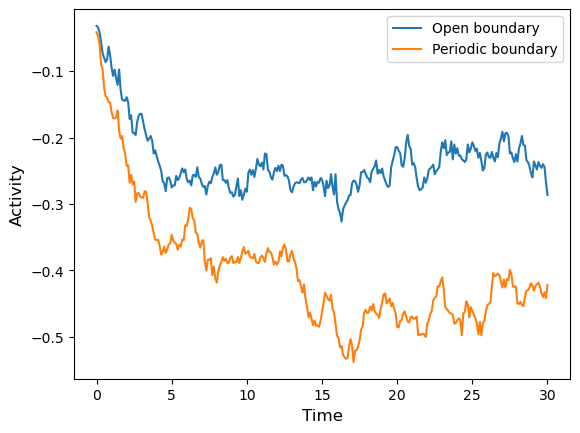

In [426]:
Ns = 100
tf = 30
tc = 0
st = 0.1
L = 5
J = 0.3
ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=120)
all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)


plt.plot(t_grid,np.mean(all_samples,axis=(0,-1,-2)),label='Open boundary')

ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=120,open_boundary=False)
all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

plt.plot(t_grid,np.mean(all_samples,axis=(0,-1,-2)),label='Periodic boundary')

plt.xlabel('Time',size=12)
plt.ylabel('Activity',size=12)
plt.legend()
plt.show()

/tmp/ipykernel_3938604/1847641206.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


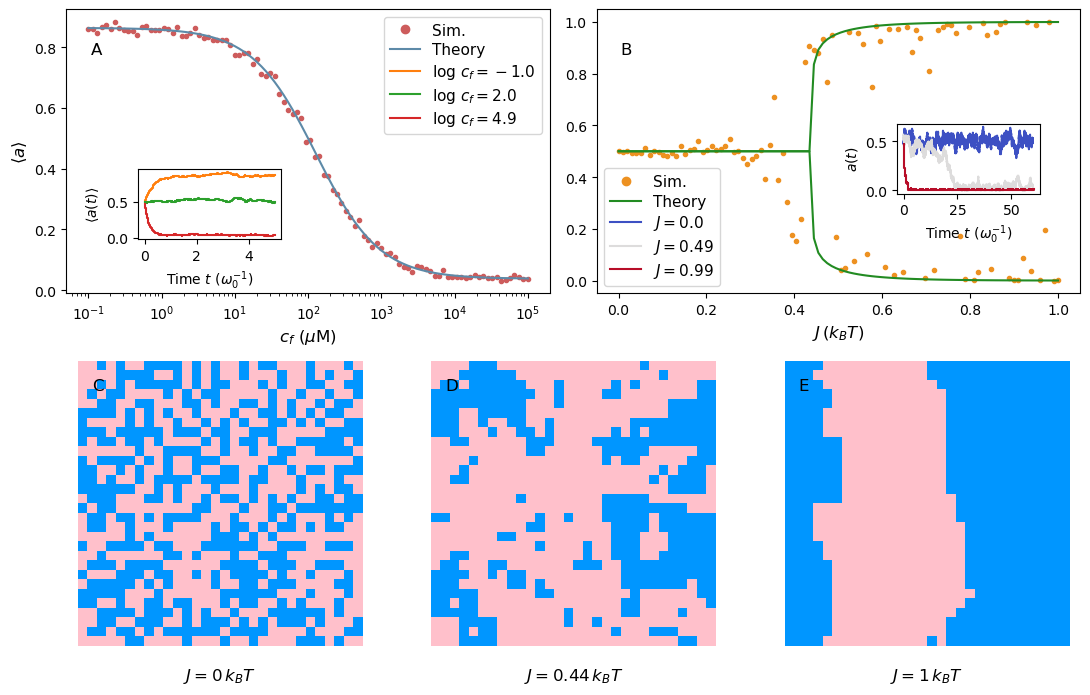

In [427]:
# preparation
fig_ising_benchmarks = plt.figure(figsize=(11,7))

# create subplots
gs = gridspec.GridSpec(2, 6)
ax1 = plt.subplot(gs[0,:3])

# create insets
left, bottom, width, height = [0.13, 0.65, 0.13, 0.1]
axx = fig_ising_benchmarks.add_axes([left, bottom, width, height])

ax2 = plt.subplot(gs[0,3:])

left, bottom, width, height = [0.82, 0.715, 0.13, 0.1]
axy = fig_ising_benchmarks.add_axes([left, bottom, width, height])

ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:])

#################
## No coupling ##
#################

# parameters
Ns = 10
tf = 5
tc = 0
st = 0.01
L = 10

# prep
J = 0
c_arr = np.logspace(-1,5,100)
avg_act = np.empty(c_arr.size)
color_counter = 1

# loop through various concentrations
handles = []
handles.append(Line2D([],[],color=my_red,marker='o',linestyle='None',label='Sim.'))
handles.append(Line2D([],[],color=my_blue,label='Theory'))

for k,c in enumerate(c_arr):    
    # obtain average magnetisation at equilibrium
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c,open_boundary=False)
    all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
    avg_act[k] = 0.5*np.mean(all_samples,axis=(0,-1,-2))[-1] + 0.5
    
    # plot realisations in the inset for some exemplars
    if k % (c_arr.size//2 - 1) == 0:
        axx.step(t_grid,0.5*np.mean(all_samples,axis=(0,-1,-2)) + 0.5,color=colormap_aux(color_counter),
                 where='post',label=f'log $c_f={np.round(np.log10(c),1)}$')
        handles.append(Line2D([],[],color=colormap_aux(color_counter),label=f'log $c_f={np.round(np.log10(c),1)}$'))
        color_counter += 1

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
ax1.semilogx(c_arr,avg_act,'.',label='Simulation',color=my_red)
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory',color=my_blue,alpha=1)
ax1.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax1.set_ylabel(r'$\langle a \rangle$',size=12)
ax1.text(0.05,0.84,'A',size=12,transform = ax1.transAxes)
ax1.legend(handles=handles,ncol=1,fontsize=11,loc='upper right',labelspacing=0.3,columnspacing=0.8)

# inset formatting
axx.set_xlabel(r'Time $t$ $(\omega_0^{-1})$',size=10)
axx.set_ylabel(r'$\langle a(t) \rangle$',size=10)
axx.tick_params(axis='both', which='major', labelsize=10)

######################
## Phase transition ##
######################

# preparation
J_arr = np.linspace(0,1,100)
avg_act = np.empty(J_arr.size)
Ns = 1
tf = 60
tc = tf + 1
st = 0.01
c0 = 100
L = 10

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',linestyle='None',label='Sim.'))
handles.append(Line2D([],[],color=my_green,label='Theory'))

# loop through various concentrations
for j,J in enumerate(J_arr):
    # obtain average magnetisation at equilibrium
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c0,c0=c0,open_boundary=False)
    lattice_mean = np.mean(ensemble[0],axis=(-1,-2))
    avg_act[j] = 0.5*np.average(lattice_mean[100:-1],weights=all_tau[0][101:]) + 0.5
    
    # plot realisations in the inset for some exemplars
    if j % (J_arr.size//2 - 1) == 0:
        axy.step(np.cumsum(all_tau[0]),0.5*lattice_mean + 0.5,color=colormap((j+1)/J_arr.size),
                 where='post',label=f'$J={np.round(J,2)}$')
        handles.append(Line2D([],[],color=colormap((j+1)/J_arr.size),label=f'$J={np.round(J,2)}$'))

# theoretical result for an infinite system
def theoretical_act(J,Jcrit=0.5*np.log(1+np.sqrt(2))):
    return np.piecewise(J, [J < Jcrit, J >= Jcrit], [0.5, lambda J: 0.5 + 0.5*((1 - (np.sinh(2*J))**-4)**(1/8))])

# show results
ax2.plot(J_arr,avg_act,'.',label='Simulation',color=my_yellow)
ax2.plot(J_arr,theoretical_act(J_arr),color=my_green)
ax2.plot(J_arr,1-theoretical_act(J_arr),color=my_green,alpha=1)
ax2.set_xlabel(r'$J \, (k_B T)$',size=12)
ax2.text(0.05,0.84,'B',size=12,transform = ax2.transAxes)
ax2.legend(handles=handles,ncol=1,fontsize=11,loc='lower left',labelspacing=0.3,columnspacing=0.8)

# inset formatting
axy.set_xlabel(r'Time $t$ $(\omega_0^{-1})$',size=10)
axy.set_ylabel(r'$a(t)$',size=10)
axy.tick_params(axis='both', which='major', labelsize=10)

##########################
## Spatial organisation ##
##########################

# formatting
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()

# parameters
Ns = 1
tf = 70
tc = tf + 1
L = 30
c0 = 100
J_list = [0,0.44,1]

# for formatting
text_list = ['C','D','E']
cmap = matplotlib.colors.ListedColormap(['#FFC0CB','#0096FF'])

for i,ax in enumerate((ax3, ax4, ax5)):
    # obtain data and show lattice
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J_list[i],cf=c0,c0=c0,open_boundary=False)
    ax.imshow(0.5 + 0.5*ensemble[0][-1],cmap=cmap)
    ax.set_title(f'$J={J_list[i]} \, k_B T$', y=-0.15, size=12)
    ax.text(0.05,0.9,text_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()
#plt.margins(x=0,y=0)
plt.show()

In [428]:
# fig_ising_benchmarks.savefig('Figures/ising_benchmarks.pdf')

<IPython.core.display.Javascript object>


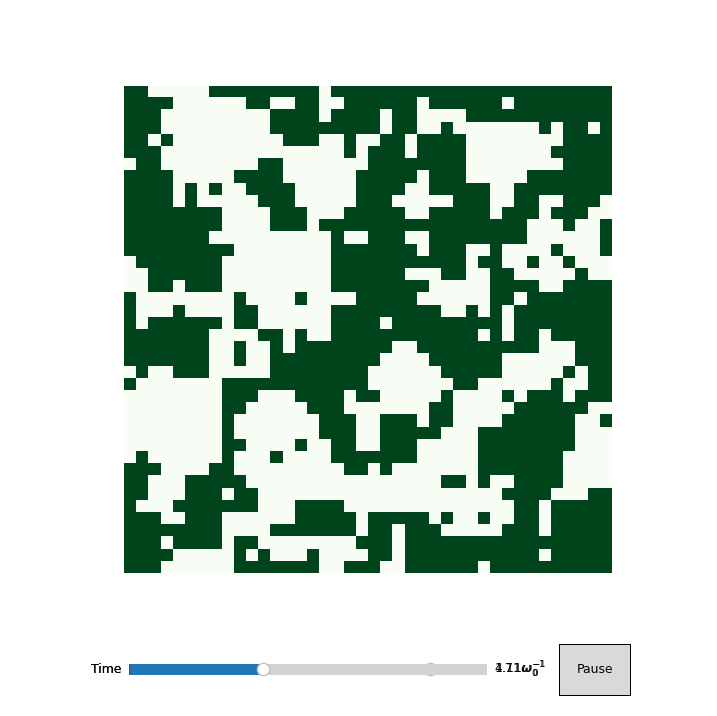

In [14]:
# interactive plot
%matplotlib notebook

# parameters
Ns = 1
tf = 5
tc = tf + 1
c0 = 100
L = 40
J = 0.4

ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,c0=c0,open_boundary=False)

# show the receptor cluster dynamically
fig = plt.figure(figsize=(8,8))

# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

# formatting
ax.set_axis_off()

# extract image objects for colorbars
# im = ax.imshow(ensemble[0][0], cmap=plt.cm.gray)

# create a timeline for the animation
timeline = amp.Timeline(np.cumsum(all_tau), units=r'$\omega_0^{-1}$', fps=10)

# create animation blocks for the lattices
realisation = np.array(ensemble[0])
block = amp.blocks.Imshow(0.5*realisation + 0.5, cmap=plt.cm.Greens)

# create the animation and add a time bar
anim = amp.Animation([block], timeline)
anim.controls()

plt.show()

<IPython.core.display.Javascript object>


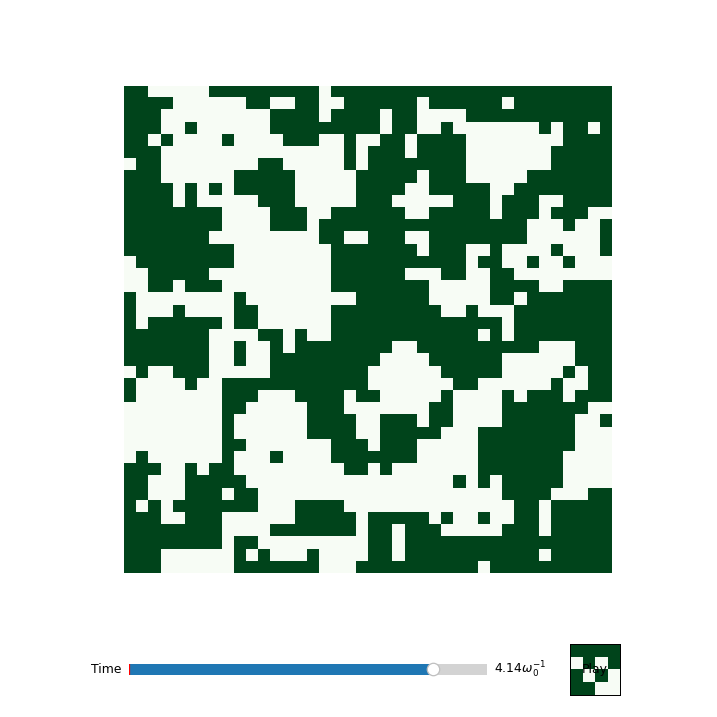

In [26]:
# show the receptor cluster dynamically
fig = plt.figure(figsize=(8,8))

# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

# formatting
ax.set_axis_off()

# create a timeline for the animation
timeline = amp.Timeline(np.cumsum(all_tau)[::10], units=r'$\omega_0^{-1}$', fps=100)

# create animation blocks for the lattices
realisation = np.array(ensemble[0][::10])
block = amp.blocks.Imshow(0.5*realisation + 0.5, cmap=plt.cm.Greens)

# create the animation and add a time bar
anim = amp.Animation([block], timeline)
anim.controls()

plt.show()

In [27]:
anim.save_gif('Figures/Ising_animation.gif')

In [29]:
%matplotlib inline


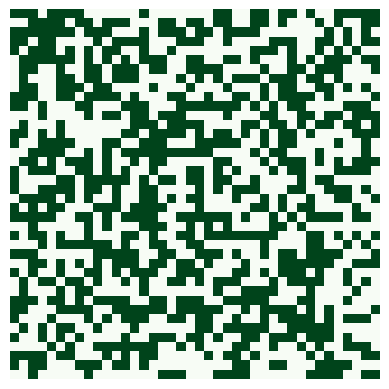

In [34]:
# parameters
Ns = 1
tf = 5
tc = tf + 1
c0 = 100
L = 40
J = 0.

ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,c0=c0,open_boundary=False)

# create animation blocks for the lattices
realisation = np.array(ensemble[0][-1])

# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

# formatting
ax.set_axis_off()

ax.imshow(0.5*realisation+0.5,cmap=plt.cm.Greens)
plt.show()

### Dose-response curves

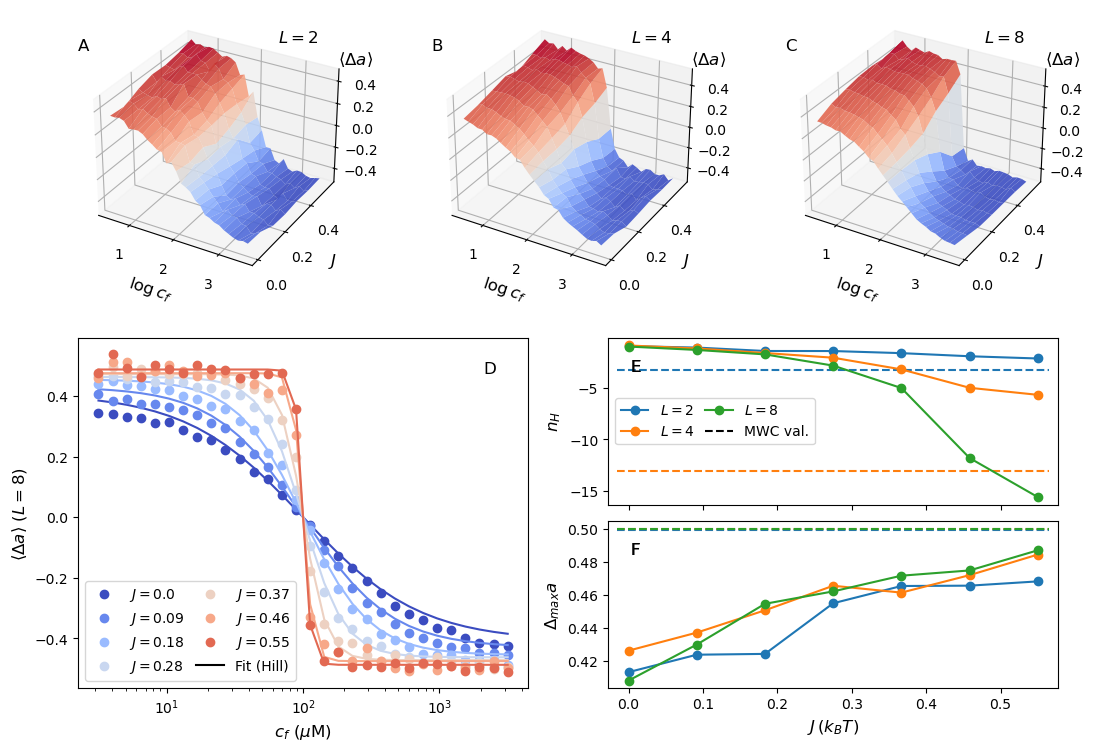

In [418]:
# preparation
fig_ising_drc = plt.figure(figsize=(11,8))
gs = gridspec.GridSpec(4, 6)

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

##############
## 3D plots ##
##############

ax1 = fig_ising_drc.add_subplot(gs[0:2,:2], projection='3d')
ax2 = fig_ising_drc.add_subplot(gs[0:2,2:4], projection='3d')
ax3 = fig_ising_drc.add_subplot(gs[0:2,4:], projection='3d')
ax4 = fig_ising_drc.add_subplot(gs[2:,:3])
ax5 = fig_ising_drc.add_subplot(gs[2,3:])
ax6 = fig_ising_drc.add_subplot(gs[3,3:],sharex=ax5)

Ns = 250
tf = 100
tc = 5
st = 0.1

L_arr = np.array([2,4,8])
J_arr = np.linspace(0.,0.55,7)
c_arr = np.logspace(0.5,3.5,30)

J_plot, c_plot = np.meshgrid(J_arr,c_arr)

delta_a = np.zeros((L_arr.size,J_arr.size,c_arr.size),dtype='float64')
hill_parm_arr = np.zeros((2,L_arr.size,J_arr.size))
hill_sds_arr = np.zeros_like(hill_parm_arr)

text_list = ['A','B','C']
handles = []

for l,ax in enumerate((ax1,ax2,ax3)):
    L = L_arr[l]
    for j,J in enumerate(J_arr):
        for k,c in enumerate(c_arr):
            # obtain an ensemble and sample
            ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c)
            all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

            # compute average activity and take pre- and post-stimulus activity
            av_act = 0.5*np.mean(all_samples,axis=(0,-1,-2)) + 0.5

            a_pre = av_act[int(tc//st) - 1]
            a_post = av_act[-1]
            delta_a[l,j,k] = a_post - a_pre # response
            
        # perform fitting of hill function
        popt, pcov = curve_fit(hill_function,c_arr,delta_a[l,j,:],maxfev=5000,bounds=([-np.inf,0],[0,np.inf]))
        hill_parm_arr[:,l,j] = popt
        hill_sds_arr[:,l,j] = [np.sqrt(pcov[i,i]) for i in range(2)]
            
        # show slices for some results
        if L == L_arr[-1]:
            color = colormap(j/J_arr.size)
            ax4.semilogx(c_arr,delta_a[l,j,:],'o',label=f'$J={J}$',color=color)
            ax4.semilogx(c_arr,hill_function(c_arr,*hill_parm_arr[:,l,j]),color=color)
            handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
            
    ax.plot_surface(np.log10(c_plot).T, J_plot.T, delta_a[l,:,:],cmap=plt.cm.coolwarm,alpha=0.9)
    ax.set_xlabel(r'$\log c_f$',size=12)
    ax.set_ylabel('$J$',size=12)
    ax.text2D(0.95,0.8,r'$\langle \Delta a \rangle$',size=12,transform = ax.transAxes)
    ax.text2D(0,0.85,text_list[l],size=12,transform = ax.transAxes)
    ax.text2D(0.73,0.88,f'$L={L_arr[l]}$',size=12,transform = ax.transAxes)

# figure formatting
handles.append(Line2D([],[],color='k',label='Fit (Hill)'))
ax4.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax4.set_ylabel(r'$\langle \Delta a \rangle$ ($L = '+str(L_arr[-1])+'$)',size=12)
ax4.legend(handles=handles,fontsize=10,columnspacing=0.8,ncol=2,loc='lower left')
ax4.text(0.9,0.9,'D',size=12,transform = ax4.transAxes)

text_list = ['E','F']
handles = []
for i,ax in enumerate((ax5,ax6)):
    for l,L in enumerate(L_arr):
        color = colormap_aux(l)
        ax.plot(J_arr,hill_parm_arr[i,l,:],'-o',label=f'$L={L}$',color=color)
        # ax.fill_between(J_arr,hill_parm_arr[i,l,:]-hill_sds_arr[i,l,:],
        #                 hill_parm_arr[i,l,:]+hill_sds_arr[i,l,:],alpha=0.4,color=color)
        ax.text(0.05,0.8,text_list[i],size=12,transform = ax.transAxes)
        
        if i == 0 and L < L_arr[-1]:
            ax.axhline(y=(L**2)*100*(18-2900)/((18+100)*(2900+100)),xmin=0.02,xmax=0.98,color=color,ls='--')
        elif i == 1:
            ax.axhline(y=(1/(1+((1+100/2900)/(1+100/18))**(L**2))-0.5),xmin=0.02,xmax=0.98,color=color,ls='--')
            handles.append(Line2D([],[],color=color,marker='o',label=f'$L={L}$'))
        
# formatting
handles.append(Line2D([],[],color='k',linestyle='--',label='MWC val.'))
ax5.set_ylabel(r'$n_H$',size=12)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.legend(handles=handles,fontsize=10,ncol=2,columnspacing=0.8)

ax6.set_ylabel(r'$\Delta_{max} a$',size=12)
ax6.set_xlabel('$J \, (k_B T)$',size=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

plt.show()

In [419]:
# fig_ising_drc.savefig('Figures/ising_drc.pdf')

### Convergence: strong coupling

In [376]:
# self-consistency relation
def scr(m,J,c,q=4,Ki=18,Ka=2900):
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    return m-np.tanh(q*J*m + H)

# derivative of the scr; necessary for numerical solver
def scr_deriv(m,J,c,q=4,Ki=18,Ka=2900):
    epsilon0 = -np.log((1+100/Ki)/(1+100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    return 1-q*J+q*J*(np.tanh(q*J*m+H))**2

def my_solver(guess,J,c,maxev=1000,tol=10**-6):
    '''
    Numerically solves the self-consistency relation for the mean-field Ising
    model based on Newton's method.
    
    Parameters
    ----------
    guess: 1d array
        initial guess for the solutions of the scr
    J: float
        coupling strength in units of kBT
    c: float
        ligand concentration in microM
    maxev: int, optional
        maximum number of iterations of the algorithm. Default is 1000
    tol: float, optional
        tolerance of the algorithm. Default is 10^-6
        
    Returns
    ----------
    sol: 1d array
        numerical solutions of the scr. Solutions for which the algorithm has not 
        converged are set to -2 and should be removed later
    '''
    # intialise
    sol = guess
    err = scr(sol,J,c)
    counter = 0
    
    # apply Newton's method until convergence
    while np.any(np.abs(err) > tol):
        sol = sol - scr(sol,J,c)/scr_deriv(sol,J,c)
        err = scr(sol,J,c)
        counter += 1
        
        if counter >= maxev:
            break
    
    # manually remove solutions that have not converged
    sol[np.abs(err) > tol] = -2.
    
    return sol

-0.3178135445103274
-0.31781349370965467
-0.3178135709752243


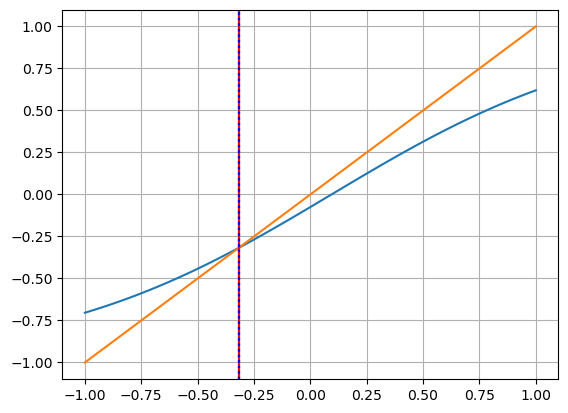

err. for fsolve [-6.96442903e-13 -1.15737420e-11  4.18831636e-13]
err. for newton [-1.42654321e-08 -3.82582854e-13 -2.16968905e-08]


In [377]:
# compare my numerical solver against fsolve
c = 120
epsilon0 = -np.log((1 + 100/18)/(1 + 100/2900))
H = -0.5*(epsilon0 + np.log((1+c/18)/(1+c/2900)))
x = np.linspace(-1,1,100)
J = 0.28

guess = np.array([-1.,0.,1.])

# check my numerical solver versus fsolve
my_sol = my_solver(guess,J,c)
fsolve_sol = fsolve(scr,guess,args=(J,c),maxfev=1000)

plt.plot(x,np.tanh(4*J*x + H),label=f'tanh$(qJm + H)$')
plt.plot(x,x,label='$m$')
for i in fsolve_sol:
    plt.axvline(x=i,color='r')
    
for i in my_sol:
    print(i)
    if np.abs(i) < 1:
        plt.axvline(x=i,color='b',ls=':')
        
plt.grid()
plt.show()

print('err. for fsolve', scr(fsolve_sol,J,c))
print('err. for newton', scr(my_sol,J,c))

In [390]:
# function for calculating the theoretical ratio based on a mean-field theory
def ratio_mfa(J,c,N,q=4,Ki=18,Ka=2900):
    '''
    Computes the ratio of the probability of being inactive versus active for the 
    mean-field Ising model based on solutions of the self-consistency relation.
    
    Parameters
    ----------
    J: float
        coupling strength in units of kBT
    c: float
        ligand concentration in microM
    N: int
        number of receptors
    q: int, optional
        number of neighbours. Default is 4
    Ki, Ka: float, optional
        dissociation constants for the inactive and active state, resp.
        Defaults are 18 and 2900 microM.
        
    Returns
    ----------
    ratio: float
        ratio of the probability of inactivity versus activity, estimated as
        p(-F(m_min))/p(-F(m_plus)), where F is the mfa free energy and m_min and
        m_plus are stable solutions of the self-consistency relation
    '''
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    # this solves the self-consistency relation
    roots = my_solver(np.array([-1.,0.,1.]),J,c)
    
    # extract only the outer two solutions
    m_min = roots[0]
    m0 = roots[1]
    m_plus = roots[-1]
        
    # calculate ratio using analytical expression if two distinct outer solution branches exist
    if np.isclose([m_min],[m0]) or np.isclose([m0],[m_plus]) or np.isclose([m_min],[m_plus]):
        return -1
    else:
        prefac = np.exp(-0.5*q*J*(m_min**2 - m_plus**2))
        cosh_ratio = np.cosh(q*J*m_min + H)/np.cosh(q*J*m_plus + H)
    
        return (prefac*cosh_ratio)**N

# theoretical estimate of the desired ratio based on MWC
def mwc_ratio(c,N=6,Ki=18,Ka=2900):
    epsilon0 = -N*np.log((1 + 100/Ki)/(1 + 100/Ka))
    return np.exp(epsilon0)*((1 + c/Ki)/(1 + c/Ka))**N

[0.08927576 0.08927576 0.08927576]
[0.2360481 0.2360481 0.2360481]
[-0.51710931 -0.41431671  0.80955998]
[-0.9364625  -0.09763709  0.9587604 ]
[-0.98465491 -0.05742128  0.98951108]
[-0.99592875 -0.04069842  0.99717491]
[0.02795832 0.02795832 0.02795832]
[0.07725381 0.07725381 0.07725381]
[-0.7010734  -0.10111556  0.76411749]
[-0.94548166 -0.0304076   0.95235301]
[-0.98655042 -0.01792791  0.98805719]
[-0.99641051 -0.01271195  0.99679772]
[-0.02636345 -0.02636345 -0.02636345]
[-0.07288908 -0.07288908 -0.07288908]
[-0.76268842  0.09521011  0.70337696]
[-0.95217185  0.02867111  0.94569372]
[-0.98801677  0.0169046   0.98659611]
[-0.99678728  0.01198643  0.9964222 ]
[-0.07482216 -0.07482216 -0.07482216]
[-0.2005717 -0.2005717 -0.2005717]
[-0.80023343  0.30267515  0.59961182]
[-0.9573415   0.08167894  0.93875312]
[-0.98918506  0.04807648  0.98512756]
[-0.99709002  0.03407975  0.99604832]


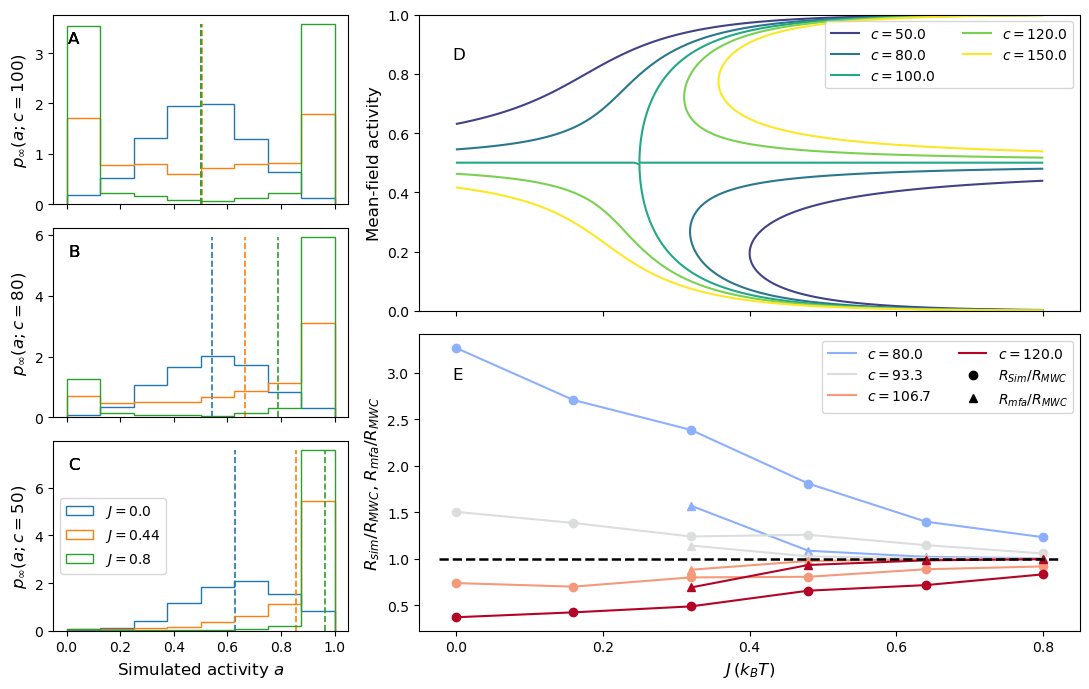

In [387]:
# preparation
fig_convergence = plt.figure(figsize=(11,7))
gs = gridspec.GridSpec(6, 3)

##############################
## Stationary distributions ##
##############################

ax3 = fig_convergence.add_subplot(gs[4:,0])
ax1 = fig_convergence.add_subplot(gs[0:2,0],sharex=ax3)
ax2 = fig_convergence.add_subplot(gs[2:4,0],sharex=ax3)

# parameters
Ns = 5000
tf = 100
tc = 0
st = 0.1
L = 3
N = L**2

J_arr = np.array([0.,0.44,0.8])
c_arr = np.array([100.,80.,50.])
text_list = ['A','B','C']

# for various J in absence of external field
for i,ax in enumerate((ax1, ax2, ax3)):
    for j,J in enumerate(J_arr):
        # set concentration and color
        c = c_arr[i]
        color = colormap_aux(j)
        
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_samples[:,-1,:,:],axis=(1,2))
        
        # plot distributions along with mean
        ax.hist(last_act,bins=8,density=True,histtype='step',color=color,label=f'$J={J}$')
        ax.axvline(x=np.mean(last_act),ymin=0.0,ymax=0.95,ls='--',color=color,linewidth=1.2)
        ax.text(0.05,0.85,text_list[i],size=12,transform = ax.transAxes)
        
    ax.set_ylabel(r'$p_\infty(a; c = '+str(int(c))+')$',size=12)

# formatting
ax3.legend(fontsize=10,loc='center left')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.set_xlabel(r'Simulated activity $a$',size=12)

#########################
## Bifurcation diagram ##
#########################

ax5 = fig_convergence.add_subplot(gs[3:,1:])
ax4 = fig_convergence.add_subplot(gs[0:3,1:],sharex=ax5)

# reset the coupling strengths and concentrations
c_arr = np.array([50.,80.,100.,120.,150.])
J_arr = np.linspace(0.,0.8,6)

# show the bifurcation diagram of the mean-field Ising model
m = np.linspace(-1,1,100)
J = np.linspace(J_arr[0],J_arr[-1],100)
m, J = np.meshgrid(m, J)

# transform to activity
a = 0.5*m + 0.5
handles = []

# solve the src for various c
for i,c in enumerate(c_arr):
    # set color
    color = colormap_viridis((i+0.99)/c_arr.size)
    cmap = matplotlib.colors.ListedColormap([color,color])
    
    # solve the self-consistency relation
    z = scr(m,J,c)
    ax4.contour(J, a, z, levels=[0], cmap=cmap)
    
    # legend formatting
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))

# formatting
ax4.legend(handles=handles,fontsize=10,ncol=2)
ax4.set_ylabel(r'Mean-field activity',size=12)
ax4.text(0.05,0.85,'D',size=12,transform = ax4.transAxes)
plt.setp(ax4.get_xticklabels(), visible=False)

#################
## Convergence ##
#################

# perform for various c
c_arr = np.linspace(80.,120.,4)

# store results
ratio_sim = np.zeros((c_arr.size,J_arr.size),dtype='float32')
ratio_mfa_arr = np.zeros_like(ratio_sim)
handles = []

for k,c in enumerate(c_arr):
    # set a color and format legend
    color = colormap((k+0.99)/c_arr.size)
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))
    
    # increase J systematically
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_samples[:,-1,:,:],axis=(1,2))

        # estimate the ratio
        ratio_sim[k,j] = np.sum(last_act < 0.5)/np.sum(last_act > 0.5)
        ratio_mfa_arr[k,j] = ratio_mfa(J,c,N)

    # check where the mfa ratio is well-defined
    mask = ratio_mfa_arr[k,:] >= 0.
    
    # show ratio of ratios for both sim and mfa
    ax5.plot(J_arr,ratio_sim[k,:]/mwc_ratio(c,N=N),'-o',color=color)
    ax5.plot(J_arr[mask],ratio_mfa_arr[k,mask]/mwc_ratio(c,N=N),'-^',color=color)

# formatting
handles.append(Line2D([], [], color='k', marker='o', linestyle='None', label=r'$R_{Sim}/R_{MWC}$'))
handles.append(Line2D([], [], color='k', marker='^', linestyle='None', label=r'$R_{mfa}/R_{MWC}$'))

ax5.legend(handles=handles,fontsize=10,ncol=2,loc='upper right')
ax5.set_xlabel(r'$J \, (k_B T)$',size=12)
ax5.set_ylabel(r'$R_{sim}/R_{MWC}$, $R_{mfa}/R_{MWC}$',size=12)
ax5.set_xlim(J_arr[0]-0.05,J_arr[-1]+0.05)
ax5.text(0.05,0.85,'E',size=12,transform = ax5.transAxes)
ax5.axhline(y=1,xmin=0.03,xmax=0.97,ls='--',color='k',linewidth=1.8)

plt.tight_layout()
plt.show()

In [389]:
# fig_convergence.savefig('Figures/convergence.pdf')

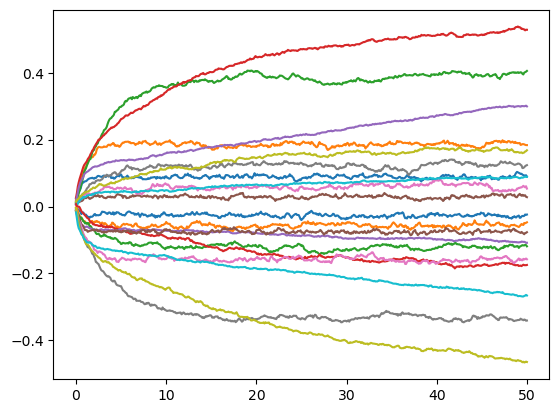

In [105]:
for k,c in enumerate(c_arr):
    # set a color and format legend
    color = colormap((k+0.99)/c_arr.size)
    handles.append(Line2D([],[],color=color,label=f'$c={np.round(c,1)}$'))
    
    # increase J systematically
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        plt.plot(t_grid,np.mean(all_samples,axis=(0,-1,-2)))


plt.show()      

### Estimating $N_\text{eff}$ 

L =  1
 Neff:  1.0038317509082608
 Neff:  1.0056992472745678
 Neff:  0.9621846326573484
 Neff:  0.9722567539060656
 Neff:  0.9830273095467768
 Neff:  0.9468915922340804
L =  2
 Neff:  1.005128305281765
 Neff:  1.3433716336822288
 Neff:  1.690197519584679
 Neff:  2.2409559399810104
 Neff:  2.7745478326115385
 Neff:  3.147164117264099
L =  3
 Neff:  0.9948614461401104
 Neff:  1.3369295668036085
 Neff:  1.8719424400265032
 Neff:  2.69493584305176
 Neff:  4.159473380285241
 Neff:  5.878631464111645
L =  4
 Neff:  0.9960004686498245
 Neff:  1.3379796977299732
 Neff:  1.8796984247329822
 Neff:  2.874823586021771
 Neff:  5.0056992569500025
 Neff:  7.804418594691005
L =  5
 Neff:  0.9969791784179033
 Neff:  1.3414240415238252
 Neff:  1.8803661065850226
 Neff:  2.915390630097731
 Neff:  5.465391630130422
 Neff:  9.442796111877986
L =  6
 Neff:  1.0040040876654532
 Neff:  1.3482074826112869
 Neff:  1.882873633079737
 Neff:  2.8458577702981245
 Neff:  5.57000565481042
 Neff:  10.807266827051368
L

/tmp/ipykernel_3938604/1431483714.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


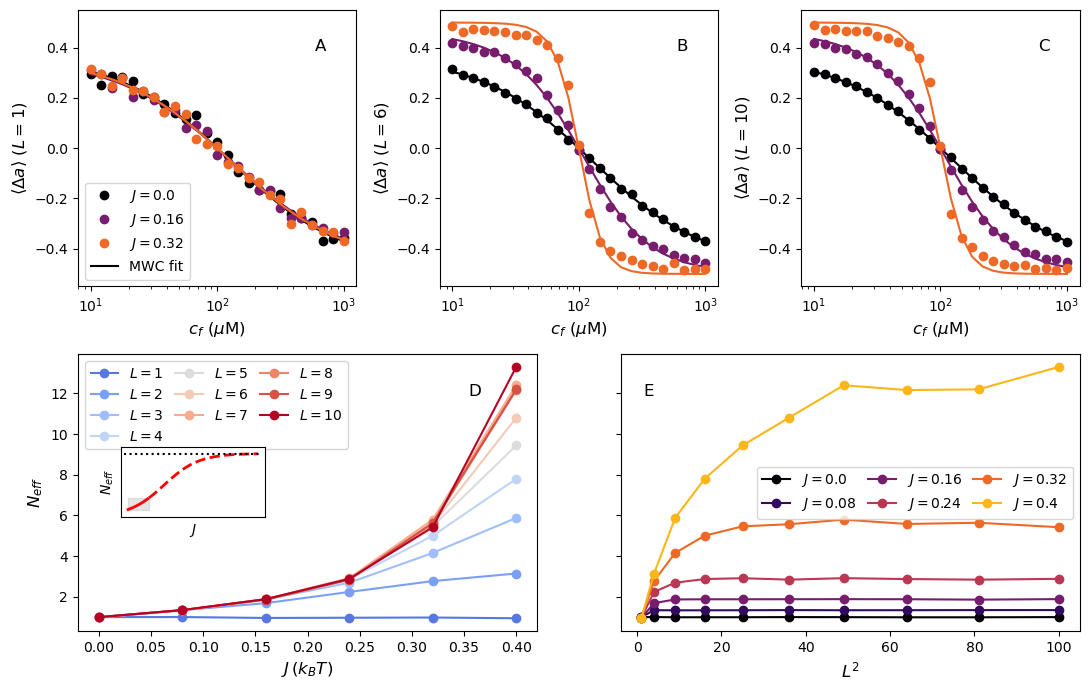

In [564]:
# define the drc for the MWC model
def drc_mwc(c,Neff):
    return pA(c,Neff)-1/2

# preparation
fig_Neff = plt.figure(figsize=(11,7))
gs = gridspec.GridSpec(2, 6)

ax1 = fig_Neff.add_subplot(gs[0,0:2])
ax2 = fig_Neff.add_subplot(gs[0,2:4],sharey=ax1)
ax3 = fig_Neff.add_subplot(gs[0,4:],sharey=ax1)

ax4 = fig_Neff.add_subplot(gs[1,:3])
ax5 = fig_Neff.add_subplot(gs[1,3:],sharey=ax4)

# insets
left, bottom, width, height = [0.115, 0.255, 0.13, 0.1]
axy = fig_Neff.add_axes([left, bottom, width, height])

# left, bottom, width, height = [0.6, 0.285, 0.13, 0.1]
# axz = fig_Neff.add_axes([left, bottom, width, height])

# parameters
Ns = 1000
tf = 35
tc = 5
st = 0.1
open_boundary = False

L_arr = np.array([1,2,3,4,5,6,7,8,9,10])
J_arr = np.linspace(0,0.4,6)
c_arr = np.logspace(1,3,25)

#################
## drcs + fits ##
#################

delta_a = np.zeros((L_arr.size,J_arr.size,c_arr.size),dtype='float64')
Neff_arr = np.zeros((L_arr.size,J_arr.size))
Neff_sds = np.zeros_like(Neff_arr)
handles = []

for l,L in enumerate(L_arr):
    print('L = ', L)
    for j,J in enumerate(J_arr):
        for k,c in enumerate(c_arr):
            # obtain an ensemble and sample
            ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c,open_boundary=open_boundary)
            all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

            # compute average activity and take pre- and post-stimulus activity
            av_act = 0.5*np.mean(all_samples,axis=(0,-1,-2)) + 0.5

            a_pre = av_act[int(tc//st) - 1]
            a_post = av_act[-1]
            delta_a[l,j,k] = a_post - a_pre # response

        # perform fitting of MWC model
        popt, pcov = curve_fit(drc_mwc,c_arr,delta_a[l,j,:],maxfev=5000,bounds=([0,np.inf]))
        Neff_arr[l,j] = popt
        Neff_sds[l,j] = np.sqrt(pcov[0,0])
        print(' Neff: ',popt[0])

        # check the fit
        if L == L_arr[0] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax1.semilogx(c_arr,delta_a[l,j,:],'o',label=f'$J={J}$',color=color)
            ax1.semilogx(c_arr,drc_mwc(c_arr,*popt),color=color)
            ax1.set_ylabel(r'$\langle \Delta a \rangle$ ($L='+str(L)+'$)',size=12)
            
            handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
            
        elif L == L_arr[int(L_arr.size/2)] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax2.semilogx(c_arr,delta_a[l,j,:],'o',label=f'$J={J}$',color=color)
            ax2.semilogx(c_arr,drc_mwc(c_arr,*popt),color=color)
            ax2.set_ylabel(r'$\langle \Delta a \rangle$ ($L='+str(L)+'$)',size=12)
            
        elif L == L_arr[-1] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax3.semilogx(c_arr,delta_a[l,j,:],'o',label=f'$J={J}$',color=color)
            ax3.semilogx(c_arr,drc_mwc(c_arr,*popt),color=color)
            ax3.set_ylabel(r'$\langle \Delta a \rangle$ ($L='+str(L)+'$)',size=12)
        
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
    ax.text(0.85,0.85,text_list[i],size=12,transform = ax.transAxes)
        
# formatting
handles.append(Line2D([],[],color='k',label=r'MWC fit'))
ax1.legend(handles=handles,fontsize=10,loc='lower left',columnspacing=0.8)

################
## Neff plots ##
################

for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax4.plot(J_arr,Neff_arr[l,:],'-o',label=f'$L={L}$',color=color)
    
ax4.set_ylabel(r'$N_{eff}$',size=12)
ax4.set_xlabel(r'$J \, (k_B T)$',size=12)
ax4.legend(fontsize=10,ncol=3,columnspacing=0.8)
ax4.text(0.85,0.85,'D',size=12,transform = ax4.transAxes)

# plot mental picture for Neff versus J
def sigmoid(x,L,c):
    return L**2/(1+np.exp(-(c*x-np.log(L**2 - 1))))

x = np.linspace(0,2.5,100)
L = 3
c = 3

axy.plot(x[x<J_arr[-1]],sigmoid(x,L,c)[x<J_arr[-1]],color='r',linewidth=2)
axy.plot(x[x>J_arr[-1]],sigmoid(x,L,c)[x>J_arr[-1]],'--',color='r',linewidth=2)
axy.axhline(y=L**2,ls=':',xmin=0.02,xmax=0.98,color='k')
axy.fill_between([0,J_arr[-1]], 1, sigmoid(J_arr[-1],L,c),alpha=0.2,color='grey')
axy.set_ylim(0,L**2+1)

axy.set_ylabel(r'$N_{eff}$',size=10)
axy.set_xlabel(r'$J$',size=10)

plt.setp(axy.get_xticklabels(), visible=False)
plt.setp(axy.get_yticklabels(), visible=False)
axy.tick_params(left = False, bottom = False)

for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr**2,Neff_arr[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)
    
ax5.set_xlabel(r'$L^2$',size=12)
ax5.legend(fontsize=10,ncol=3,columnspacing=0.8)
ax5.text(0.05,0.85,'E',size=12,transform = ax5.transAxes)
plt.setp(ax5.get_yticklabels(), visible=False)

# for m in np.linspace(0.1,0.9,5):
#     if m < J_arr[-1]:
#         ls = '-'
#     else:
#         ls = '--'
#     color = colormap_greens(1-m + 0.1)
#     axz.plot(x,m*x,ls=ls,color=color,linewidth=2)
    
# axz.plot(x,x,ls=':',color='k')
# axz.fill_between(x,0,x*J_arr[-1],alpha=0.2,color='grey')

# axz.set_ylabel(r'log $N_{eff}$',size=10)
# axz.set_xlabel(r'log $L^2$',size=10)

# plt.setp(axz.get_xticklabels(), visible=False)
# plt.setp(axz.get_yticklabels(), visible=False)
# axz.tick_params(left = False, bottom = False)

plt.tight_layout()
plt.show()

In [232]:
# fig_Neff.savefig('Figures/Neff.pdf')

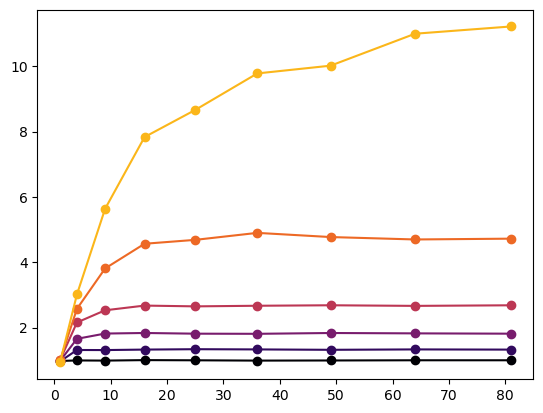

In [453]:
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    plt.plot(L_arr**2,Neff_arr[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)

### Correlation length

In [469]:
@numba.jit(nopython=True)
def indices_distinct_vals(arr):
    '''
    Numba-compatible function for finding the indices of distinct values in an array.
    
    Parameters
    ----------
    arr: ndarray
        one-dimensional numpy array
    
    Returns
    ----------
    unique: ndarray
        unique values in arr, i.e., np.unique(arr)
    indices: ndarray
        indices corresponding to the values in unique
    '''
    
    # sort the array and extract index when each distinct value occurs for the first time
    indices = np.searchsorted(np.sort(arr), np.unique(arr))
    
    # remove the first zero and add the final index manually
    return np.unique(arr), np.append(indices[1:],arr.size-1)

@numba.jit(nopython=True)
def cross_correlation(ensemble,L):
    '''
    Computes the spatial cross-correlation for an ensemble of spins.
    
    Parameters
    ----------
    ensemble: List
        ensemble of square lattices. Has dimensions (samples,time,L,L)
    L: int
        linear dimension of the lattice
    
    Returns
    ----------
    r_uniq: ndarray
        array of distinct euclidean separations in the lattice. Notice that this is
        less than L/2
    mean_cc: ndarray
        ensemble cross-correlation. Correlations are averaged over spins and 
        radial distance
    std_cc: ndarray
        ensemble standard deviation around mean_cc
    
    '''
    # set up arrays
    r_arr = np.zeros(int((L**2)*(L**2 - 1)/2),dtype='float64')
    cc = np.zeros_like(r_arr)
    counter = 0
    
    # find the cross-correlation between a spin and every other spin
    for spin1 in range(L**2):
        # determine coordinates of spin1
        m1,n1 = np.divmod(spin1,L)
        
        # only consider the spins that have not been considered
        for spin2 in range(spin1+1,L**2):
            # determine position of spin2
            m2,n2 = np.divmod(spin2,L)
            
            # compute distance and cross-correlation, and update counter
            r_arr[counter] = np.sqrt((m2-m1)**2 + (n2-n1)**2)
            cc[counter] = np.corrcoef(np.vstack((ensemble[:,-1,m1,n1],ensemble[:,-1,m2,n2])))[0,1]
            counter += 1
            
    ######################
    ## Radial averaging ##
    ######################
    
    # extract distinct distances and their indices
    r_uniq, indices_uniq = indices_distinct_vals(r_arr)
    
    # sort the cross-correlations based on r
    indices_sort = np.argsort(r_arr)
    sorted_cc = cc[indices_sort]
    
    # arrays to store sample statistics
    mean_cc = np.zeros_like(r_uniq,dtype='float64')
    std_cc = np.zeros_like(mean_cc)
    
    # prepare looping through unique indices
    idx1 = 0
    
    # actual averaging per distinct values
    for i,idx in enumerate(indices_uniq):
        mean_cc[i] = np.mean(sorted_cc[idx1:idx])
        std_cc[i] = np.std(sorted_cc[idx1:idx])
        idx1 = idx
    
    # ensure that only reasonable correlation lengths are considered
    r_mask = r_uniq <= L/2.
    
    # return the distances, cross-correlation and its standard deviation
    return r_uniq[r_mask], mean_cc[r_mask], std_cc[r_mask]

# exponential fit for extracting the correlation length
def exp_fit(r,xi):
    return np.exp(-r/xi)

L =  3
  xi:  0.44830820870803983
  xi:  0.23570035620892082
  xi:  0.755743818247079
  xi:  1.362375920312105
  xi:  1.5929000737338546
  xi:  2.836205061655769


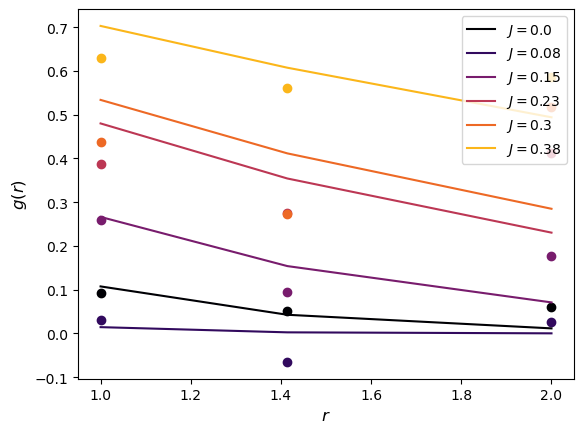

L =  4
  xi:  0.26107975643594866
  xi:  0.4090289272122595
  xi:  0.5505042220694586
  xi:  0.6955409414883467
  xi:  1.3307840429409241
  xi:  3.139213878777734


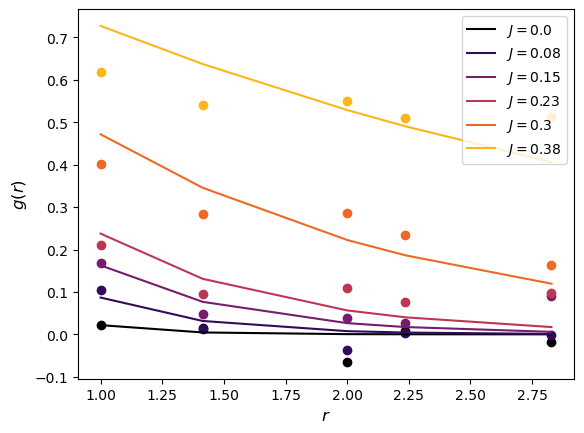

L =  5
  xi:  0.0905153185101395
  xi:  0.35717435854848656
  xi:  0.5381485815876874
  xi:  0.6343500835040727
  xi:  1.5419256872025424
  xi:  2.7036178607553545


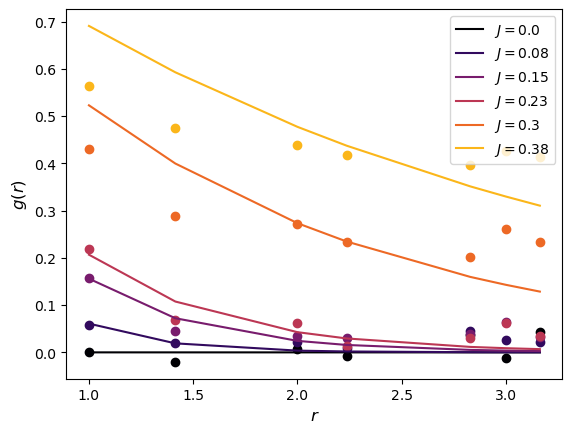

L =  6
  xi:  0.17642856575066576
  xi:  0.33903852619845865
  xi:  0.4977822893647431
  xi:  0.7257793912021537
  xi:  1.259173847565339
  xi:  2.4305402554338023


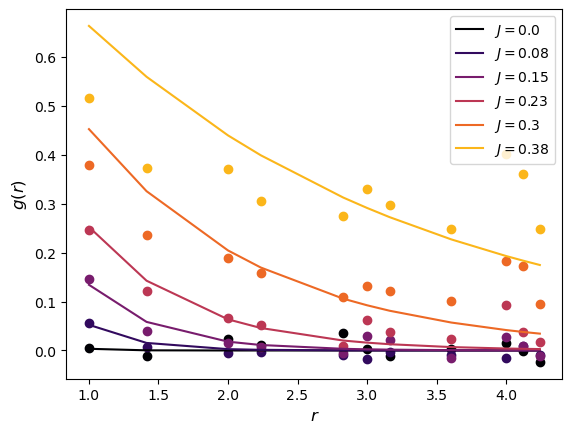

In [471]:
# set up parameters
Ns = 100
tf = 30
tc = 5
st = 0.1

# L_arr = np.array([5,6,7,8,9])
test = np.array([3,4,5,6])
large_L_arr = L_arr[L_arr > 2] # only consider large enough lattices

all_xi = np.zeros((test.size,J_arr.size),dtype='float64')
all_std_xi = np.zeros_like(all_xi)
Neff_sim_arr = np.zeros_like(all_xi)
Neff_mfa_arr = np.zeros_like(all_xi)

# consider various lattice size
for l,L in enumerate(test):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,open_boundary=False)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        # extract cross-correlation
        r_arr,mean_cc,std_cc = cross_correlation(all_samples,L)

        # extract correlation length and error bar
        popt,pcov = curve_fit(exp_fit,r_arr,mean_cc,bounds=([0.],[np.inf]))
        all_xi[l,j] = popt[0]
        all_std_xi[l,j] = np.sqrt(pcov[0,0])
        print('  xi: ',popt[0])

        # show results
        color = colormap_inferno(j/J_arr.size)
        plt.scatter(r_arr,mean_cc,color=color)
        #plt.fill_between(r_arr,mean_cc-std_cc,mean_cc+std_cc,color=color,alpha=0.2)
        plt.plot(r_arr,exp_fit(r_arr,*popt),color=color,label=f'$J = {np.round(J,2)}$')
        
    plt.xlabel(r'$r$',size=12)
    plt.ylabel(r'$g(r)$',size=12)
    plt.legend(fontsize=10)
    plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

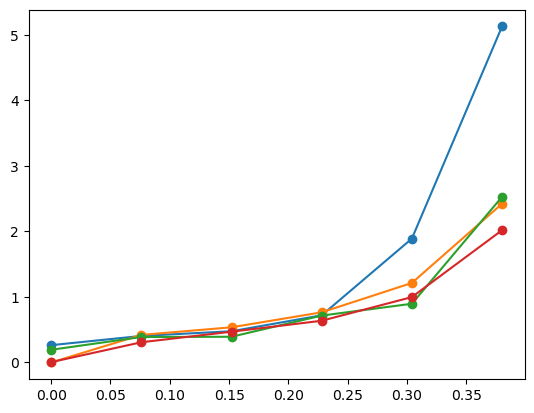

In [463]:
for l,L in enumerate(L_arr[L_arr>1]):
    plt.plot(J_arr,all_xi[l,:],'-o',label=f'$L={L}$')
    
plt.legend()
plt.show()

for l,L in enumerate(L_arr[L_arr>2]):
    plt.loglog(all_xi[l,1:],Neff_arr[l+2,1:],'-o',label=f'$L={L}$')

plt.loglog(all_xi[0,1:],all_xi[0,1:]**1.4)
plt.xlabel(r'$\xi$')
plt.ylabel(r'$N_{eff}$')
plt.legend()
plt.show()

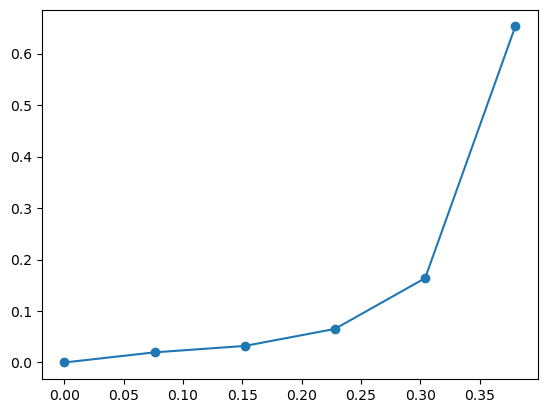

In [464]:
plt.plot(J_arr,1/(L_arr[2]/all_xi[1,:])**2,'-o')

L =  3
  xi:  0.18654355722457042
  xi:  0.4017089100415062
  xi:  0.6424564096725858
  xi:  1.1940164609843873
  xi:  2.0263377480312954
  xi:  4.323603188422625
L =  4
  xi:  0.14924744620401426
  xi:  0.38578287112066434
  xi:  0.5398845181780543
  xi:  0.8890360874192901
  xi:  1.6397325049927225
  xi:  3.7714341596955605
L =  5
  xi:  0.03586828599440095
  xi:  0.40232469171157054
  xi:  0.5518786085129712
  xi:  0.7852526021995466
  xi:  1.3850995475122967
  xi:  3.2708653470682996
L =  6
  xi:  0.13287331244643563
  xi:  0.3961770020699032
  xi:  0.5381054888564891
  xi:  0.7746951553090585
  xi:  1.3115426999968727
  xi:  3.6350404629535533
L =  7
  xi:  0.15658475990273021
  xi:  0.39013489998838097
  xi:  0.5275282316128235
  xi:  0.7445126174270669
  xi:  1.1295459474751806
  xi:  2.745282408738473
L =  8
  xi:  0.18289988001009308
  xi:  0.3882481411153825
  xi:  0.5401202123846535
  xi:  0.7403684979006359
  xi:  1.1013318320326337
  xi:  2.706618862832158
L =  9
  xi:  0.

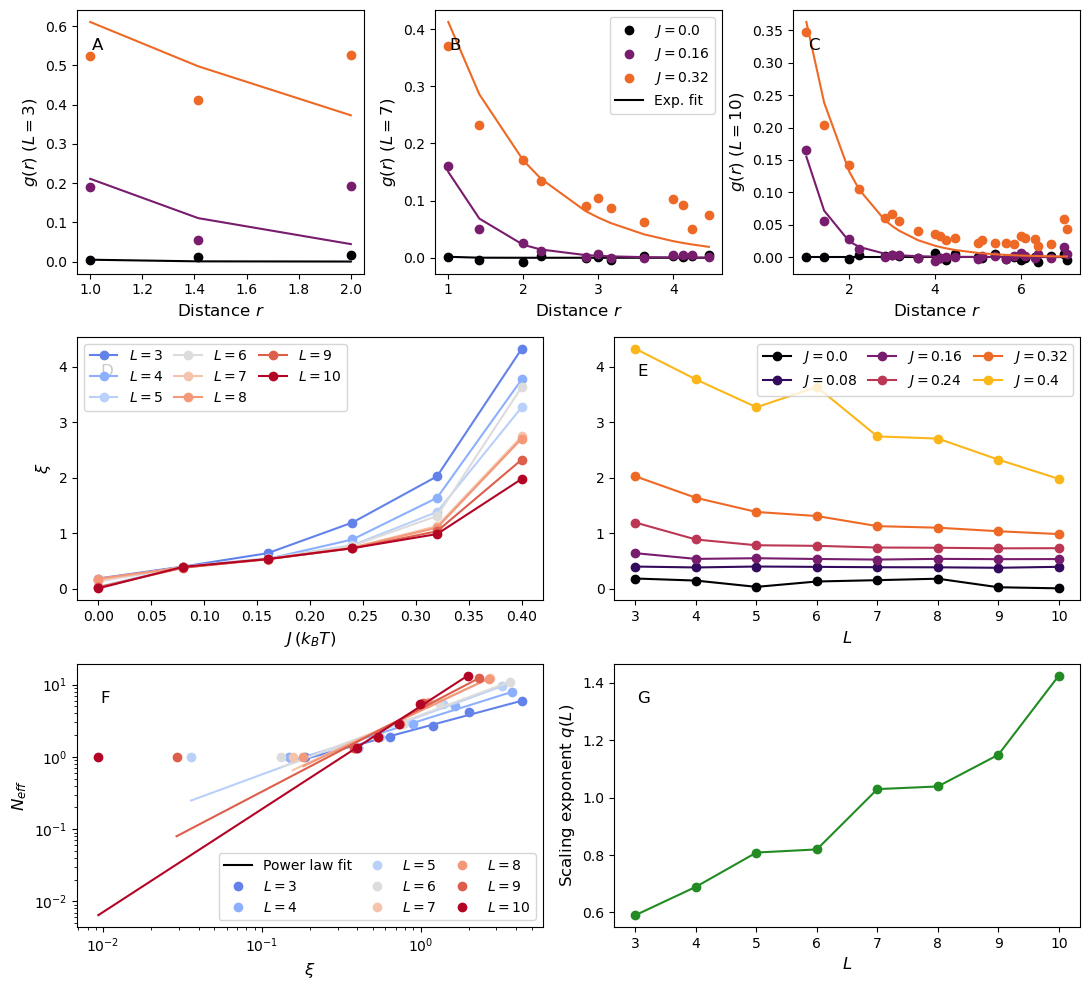

In [565]:
# preparation
fig_xi = plt.figure(figsize=(11,10))
gs = gridspec.GridSpec(3, 6)

ax1 = fig_xi.add_subplot(gs[0,0:2])
ax2 = fig_xi.add_subplot(gs[0,2:4])
ax3 = fig_xi.add_subplot(gs[0,4:])

ax4 = fig_xi.add_subplot(gs[1,:3])
ax5 = fig_xi.add_subplot(gs[1,3:])

ax6 = fig_xi.add_subplot(gs[2,:3])
ax7 = fig_xi.add_subplot(gs[2,3:])

# parameters; same as for estimating Neff
Ns = 1000
tf = 30
tc = 5
st = 0.1
open_boundary = False

################################
## Compute correlation length ##
################################

large_L_arr = L_arr[L_arr > 2] # only consider large enough lattices

all_xi = np.zeros((large_L_arr.size,J_arr.size),dtype='float64')
all_std_xi = np.zeros_like(all_xi)

handles = []

# consider various lattice size
for l,L in enumerate(large_L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        # extract cross-correlation
        r_arr,mean_cc,std_cc = cross_correlation(all_samples,L)

        # extract correlation length and error bar
        popt,pcov = curve_fit(exp_fit,r_arr,mean_cc)
        all_xi[l,j] = popt[0]
        all_std_xi[l,j] = np.sqrt(pcov[0,0])
        print('  xi: ',popt[0])
        
        # check the fit
        if L == large_L_arr[0] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax1.plot(r_arr,mean_cc,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax1.plot(r_arr,exp_fit(r_arr,*popt),color=color)
            ax1.set_ylabel(r'$g(r)$ ($L='+str(L)+'$)',size=12)
            
            handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
            
        elif L == large_L_arr[int(large_L_arr.size/2)] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax2.plot(r_arr,mean_cc,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax2.plot(r_arr,exp_fit(r_arr,*popt),color=color)
            ax2.set_ylabel(r'$g(r)$ ($L='+str(L)+'$)',size=12)
            
        elif L == large_L_arr[-1] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax3.plot(r_arr,mean_cc,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax3.plot(r_arr,exp_fit(r_arr,*popt),color=color)
            ax3.set_ylabel(r'$g(r)$ ($L='+str(L)+'$)',size=12)

# formatting
text_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel(r'Distance $r$',size=12)
    ax.text(0.05,0.85,text_list[i],size=12,transform = ax.transAxes)
        
# formatting
handles.append(Line2D([],[],color='k',label=r'Exp. fit'))
ax2.legend(handles=handles,fontsize=10,loc='upper right',columnspacing=0.8)

#############################
## Show correlation length ##
#############################

# show as a function of J
for l,L in enumerate(large_L_arr):
    color = colormap((l+1)/large_L_arr.size)
    ax4.plot(J_arr,all_xi[l,:],'-o',label=f'$L={L}$',color=color)
    
ax4.set_ylabel(r'$\xi$',size=12)
ax4.set_xlabel(r'$J \, (k_B T)$',size=12)
ax4.legend(fontsize=10,ncol=3,columnspacing=0.8)
ax4.text(0.05,0.85,'D',size=12,transform = ax4.transAxes)

# show as a function of L
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(large_L_arr,all_xi[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)
    
ax5.set_xlabel(r'$L$',size=12)
ax5.legend(fontsize=10,ncol=3,columnspacing=0.8)
ax5.text(0.05,0.85,'E',size=12,transform = ax5.transAxes)

#################
## Neff vs. xi ##
#################

# power law fitting function
def power_law(x,a,b):
    return a*(x**b)

# fitting parms
pl_parms = np.zeros((2,large_L_arr.size),dtype='float64')
pl_sds = np.zeros_like(pl_parms)

handles = []
handles.append(Line2D([], [], color='k',label=f'Power law fit'))

# show parametric plot of Neff versus xi^2
len_diff = int(np.size(L_arr) - np.size(large_L_arr))
for l,L in enumerate(large_L_arr):
    # perform fit
    popt,pcov = curve_fit(power_law,all_xi[l,:],Neff_arr[l+len_diff,:])
    pl_parms[:,l] = popt
    pl_sds[:,l] = [np.sqrt(pcov[i,i]) for i in range(2)]

    color = colormap((l+1)/large_L_arr.size)
    ax6.loglog(all_xi[l,:],Neff_arr[l+len_diff,:],'o',color=color,label=f'$L={L}$')
    ax6.loglog(all_xi[l,:],power_law(all_xi[l,:],*popt),color=color)
    
    handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$L={L}$'))
    
ax6.set_xlabel(r'$\xi$',size=12)
ax6.set_ylabel(r'$N_{eff}$',size=12)
ax6.legend(handles=handles,fontsize=10,ncol=3,columnspacing=0.8)
ax6.text(0.05,0.85,'F',size=12,transform = ax6.transAxes)

# show the scaling exponent as a function of L
ax7.plot(large_L_arr,pl_parms[1,:],'-o',color=my_green)
ax7.set_xlabel(r'$L$',size=12)
ax7.set_ylabel(r'Scaling exponent $q(L)$',size=12)
ax7.text(0.05,0.85,'G',size=12,transform = ax7.transAxes)

plt.tight_layout()
plt.show()

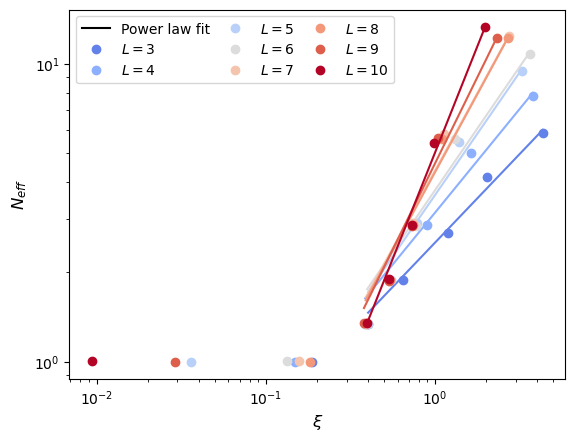

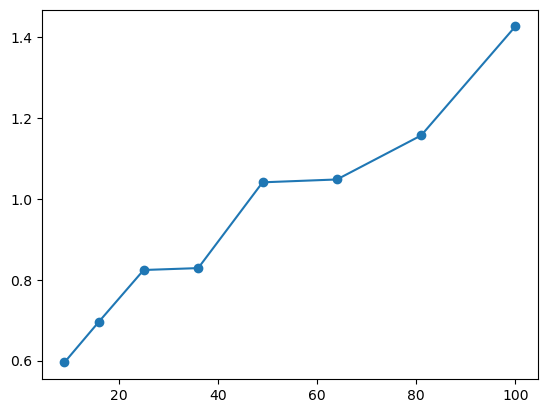

In [571]:
#################
## Neff vs. xi ##
#################

# power law fitting function
def power_law(x,a,b):
    return a*(x**b)

# fitting parms
pl_parms = np.zeros((2,large_L_arr.size),dtype='float64')
pl_sds = np.zeros_like(pl_parms)

handles = []
handles.append(Line2D([], [], color='k',label=f'Power law fit'))

# show parametric plot of Neff versus xi^2
len_diff = int(np.size(L_arr) - np.size(large_L_arr))
for l,L in enumerate(large_L_arr):
    # perform fit
    popt,pcov = curve_fit(power_law,all_xi[l,1:],Neff_arr[l+len_diff,1:])
    pl_parms[:,l] = popt
    pl_sds[:,l] = [np.sqrt(pcov[i,i]) for i in range(2)]

    color = colormap((l+1)/large_L_arr.size)
    plt.loglog(all_xi[l,:],Neff_arr[l+len_diff,:],'o',color=color,label=f'$L={L}$')
    plt.loglog(all_xi[l,1:],power_law(all_xi[l,1:],*popt),color=color)
    
    handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$L={L}$'))
    
plt.xlabel(r'$\xi$',size=12)
plt.ylabel(r'$N_{eff}$',size=12)
plt.legend(handles=handles,fontsize=10,ncol=3,columnspacing=0.8)
plt.show()

# show the scaling exponent as a function of L
plt.plot(large_L_arr**2,pl_parms[1,:],'-o')

plt.show()

### Response kernel

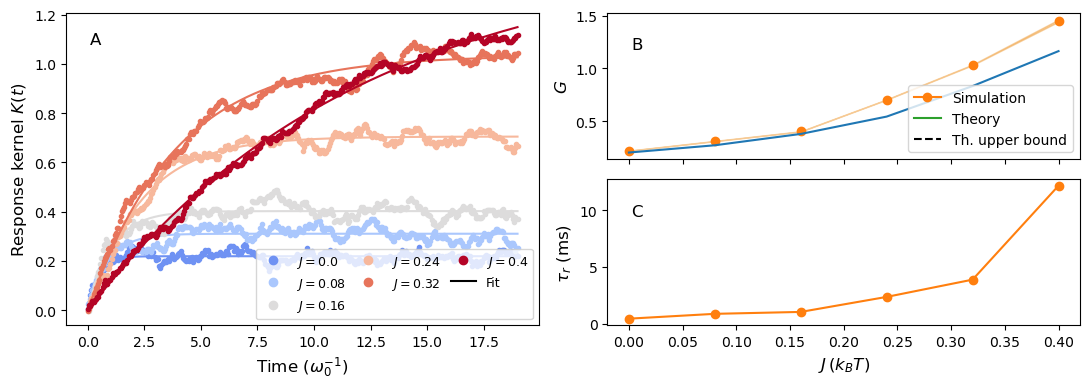

In [566]:
# nonadaptive response kernel
def rk_star(t,G,tau_r):
    return G*(1-np.exp(-t/tau_r))

# preparation
fig_rk_ising_na = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

Ns = 5000
tf = 24
tc = 5
st = 0.05
L = 3
c0 = 100
cf = 90

rk_parms = np.zeros((2,J_arr.size),dtype='float64')
rk_sds = np.zeros_like(rk_parms)
handles = []

for j,J in enumerate(J_arr):
    # obtain an ensemble and sample
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,c0=c0,open_boundary=False)
    all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
    
    # find response kernel
    av_act = 0.5*np.mean(all_samples,axis=(0,-1,-2)) + 0.5
    response = (av_act[t_grid >= tc] - av_act[int(tc/st)-1])/np.log(c0/cf)
    time_s = t_grid[t_grid >= tc] - tc
    
    # fitting
    popt, pcov = curve_fit(rk_star,time_s,response)
    rk_parms[:,j] = popt
    rk_sds[:,j] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    color = colormap((j+1)/J_arr.size)
    ax1.plot(time_s,response,'.',color=color)
    ax1.plot(time_s,rk_star(time_s,*popt),color=color)
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='lower right',fontsize=9,ncol=3,columnspacing=0.8)
ax1.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
ax1.set_ylabel(r'Response kernel $K(t)$',size=12) 
ax1.text(0.05,0.9,'A',size=12,transform = ax1.transAxes)

# ax2.plot(N_arr,(pA(cf,N_arr)-0.5)/np.log(c0/cf),color=my_green,label='Theory')
ax2.plot(J_arr,rk_parms[0,:],'o',color=colormap_aux(1),label='Simulation')
ax2.fill_between(J_arr,rk_parms[0,:]-rk_sds[0,:],rk_parms[0,:]+rk_sds[0,:],color=my_yellow,alpha=0.4)
ax2.plot(J_arr,(pA(cf,Neff_arr[2,:])-0.5)/np.log(c0/cf),'-')
#ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color='k')

handles = []
handles.append(Line2D([],[],color=colormap_aux(1),marker='o',label='Simulation'))
handles.append(Line2D([],[],color=colormap_aux(2),label=f'Theory'))
handles.append(Line2D([],[],color='k',linestyle='--',label='Th. upper bound'))

ax2.legend(handles=handles,loc='lower right',fontsize=10)
ax2.set_ylabel(r'$G$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

# ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(J_arr,rk_parms[1,:],'-o',color=colormap_aux(1))
# ax3.fill_between(J_arr,(rk_parms[1,:]-rk_sds[1,:])*1000,(rk_parms[1,:]+rk_sds[1,:])*1000,color=my_yellow,alpha=0.4)
# ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color='k')

ax3.set_xlabel(r'$J \, (k_B T)$',size=12)
ax3.set_ylabel(r'$\tau_r$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

### Noise kernel

In [521]:
@numba.jit(nopython=True)
def cell_activity_ising(Ns,Nc,tf,tc,st,L,J,cf=90,open_boundary=True):
    '''
    Finds an ensemble of single-cell activities, i.e., activities averaged over the cell's clusters
    for the Ising model. Runs on Numba's nopython mode.

    Parameters
    ----------
    Ns: int
        number of samples, i.e., the number of cells in the ensemble
    Nc: int
        number of clusters per cell
    tf: float
        final time of the underlying Gillepsie simulation
    tc: float
        time at which the concentration is changed
    st: float
        sampling time period
    L: int
        linear dimension of cluster size
    J: float
        coupling strength in kBT
    cf: float, optional
        final concentration. Default is 90 microM

    Returns
    ----------
    all_cell_act: ndarray
        time-sampled traces of the activity for each cell. Shape is (Ns,int(tf/st) + 1)
    t_grid: ndarray
        times at which the time series are sampled, length int(tf/st) + 1
       
    '''
   
    # array to save result
    all_cell_act = np.zeros((Ns,int(tf/st) + 1,L,L),dtype='float64')
   
    for s in range(Ns):
        # obtain a single-cell realisation
        ensemble, all_tau = ising_simulator(Nc,tf,tc,L,J,cf=cf,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Nc,tf,st)
        # average over the cell's clusters
        all_cell_act[s,:,:,:] = np.sum(0.5*all_samples + 0.5,axis=0)/Nc
   
    return all_cell_act, t_grid

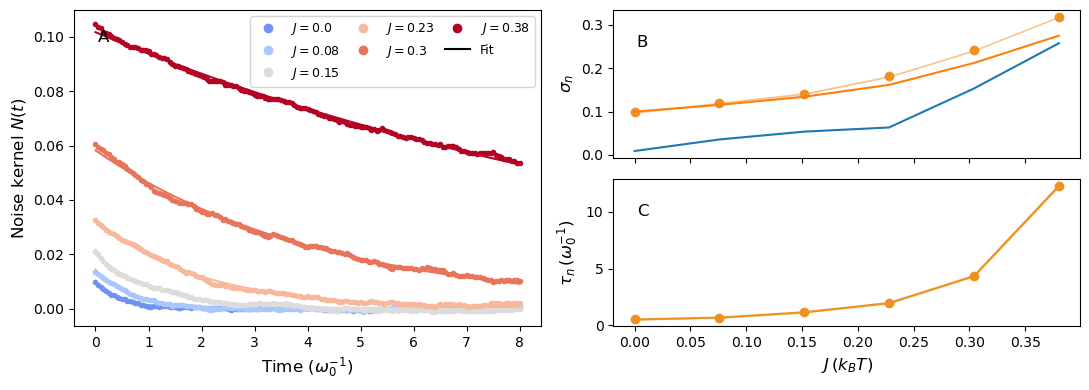

In [522]:
# noise kernel
def nk(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-np.abs(t)/tau_n)

# preparation
fig_nk_ising_na = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

Ns = 1000
Nc = 1
tf = 20
tc = 0
st = 0.05
co = int(0.6*tf/st)
L = 5
c0 = 100
cf = 90

nk_parms = np.zeros((2,J_arr.size),dtype='float64')
nk_sds = np.zeros_like(nk_parms)
handles = []

for j,J in enumerate(J_arr):
    # obtain a cell-ensemble
    cell_ensemble, t_grid = cell_activity_ising(Ns,Nc,tf,tc,st,L,J,open_boundary=False)
    cell_act = np.mean(cell_ensemble,axis=(-1,-2))
    
    # find noise kernel
    nkernel, time_s = autocorr(cell_act,t_grid,co)
    
    # fitting
    popt, pcov = curve_fit(nk,time_s,nkernel)
    nk_parms[:,j] = popt
    nk_sds[:,j] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    color = colormap((j+1)/J_arr.size)
    ax1.plot(time_s,nkernel,'.',color=color)
    ax1.plot(time_s,nk(time_s,*popt),color=color)
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='upper right',fontsize=9,ncol=3,columnspacing=0.8)
ax1.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
ax1.set_ylabel(r'Noise kernel $N(t)$',size=12) 
ax1.text(0.05,0.9,'A',size=12,transform = ax1.transAxes)

# ax2.plot(N_arr,(pA(cf,N_arr)-0.5)/np.log(c0/cf),color=my_green,label='Theory')
ax2.plot(J_arr,nk_parms[0,:],'o',color=my_yellow,label='Simulation')
ax2.plot(J_arr,np.sqrt(pA(cf,all_xi[2,:]**2)*(1-pA(cf,all_xi[2,:]**2))/(L/all_xi[2,:])**2),'-')
ax2.plot(J_arr,np.sqrt(pA(cf,Neff_arr[4,:])*(1-pA(cf,Neff_arr[4,:]))/(L**2/Neff_arr[4,:])),'-')
ax2.fill_between(J_arr,nk_parms[0,:]-nk_sds[0,:],nk_parms[0,:]+nk_sds[0,:],color=my_yellow,alpha=0.4)
#ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color='k')

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label='Simulation'))

#ax2.legend(handles=handles,loc='lower right',fontsize=10)
ax2.set_ylabel(r'$\sigma_n$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

# ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(J_arr,nk_parms[1,:],'-o',color=my_yellow)
ax3.fill_between(J_arr,nk_parms[1,:]-nk_sds[1,:],nk_parms[1,:]+nk_sds[1,:],color=my_yellow,alpha=0.4)
# ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color='k')

ax3.set_xlabel(r'$J \, (k_B T)$',size=12)
ax3.set_ylabel(r'$\tau_n \, (\omega_0^{-1})$',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [529]:
# obtain an ensemble and sample
L = 5
J = 0.38
ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,c0=c0,open_boundary=False)
all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

# find response kernel
last_act = 0.5*np.mean(all_samples[:,-1,:,:],axis=(-1,-2)) + 0.5
noise_ampl = np.var(last_act)
print(noise_ampl)

0.09484326239999999


L =  1
   noise ampl.  0.249975
   noise ampl.  0.2497439999999999
   noise ampl.  0.24955900000000003
   noise ampl.  0.2499959999999999
   noise ampl.  0.24995100000000003
   noise ampl.  0.24985600000000005
L =  2
   noise ampl.  0.0603469375
   noise ampl.  0.08749400000000002
   noise ampl.  0.11578243749999999
   noise ampl.  0.15051974999999998
   noise ampl.  0.174894
   noise ampl.  0.20097399999999999
L =  3
   noise ampl.  0.026250666666666665
   noise ampl.  0.04001529629629629
   noise ampl.  0.05695920987654321
   noise ampl.  0.08957253086419752
   noise ampl.  0.13194054320987653
   noise ampl.  0.16900123456790123
L =  4
   noise ampl.  0.014950921874999999
   noise ampl.  0.021531109375
   noise ampl.  0.03438060937499999
   noise ampl.  0.055132496093750004
   noise ampl.  0.09011077734375
   noise ampl.  0.13766593359375004
L =  5
   noise ampl.  0.009277766399999996
   noise ampl.  0.0144180464
   noise ampl.  0.021024793599999998
   noise ampl.  0.0379352815999999

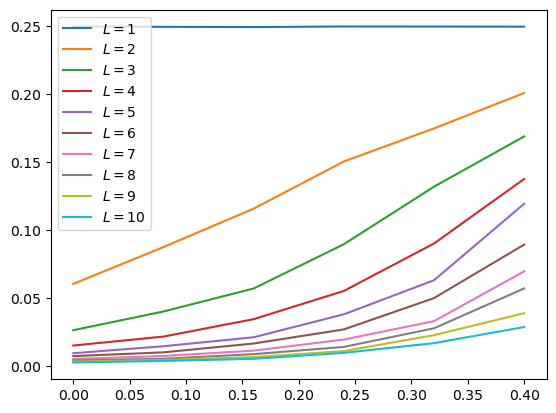

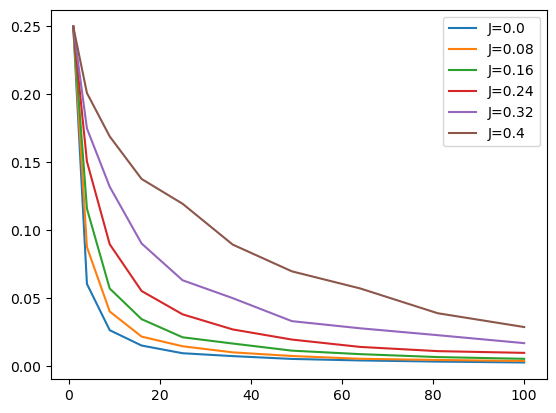

Baseline noise amplitude:  0.24984683333333332


In [567]:
# parameters
Ns = 1000
Nc = 1
tf = 20
tc = 0
st = 0.05
c0 = 100
cf = 90

noise_ampl = np.zeros((L_arr.size,J_arr.size),dtype='float64')

for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,c0=c0,open_boundary=False)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        last_act = 0.5*np.mean(all_samples[:,-1,:,:],axis=(-1,-2)) + 0.5
        print('   noise ampl. ',np.var(last_act))
        noise_ampl[l,j] = np.var(last_act)
        
    plt.plot(J_arr,noise_ampl[l,:],label=f'$L={L}$')
    
plt.legend()
plt.show()

for j,J in enumerate(J_arr):
    plt.plot(L_arr**2,noise_ampl[:,j],label=f'J={np.round(J,2)}')
    
plt.legend()
plt.show()

noise_ampl_1 = np.mean(noise_ampl[0,:])
print('Baseline noise amplitude: ',noise_ampl_1)

Nc_eff = noise_ampl_1/noise_ampl

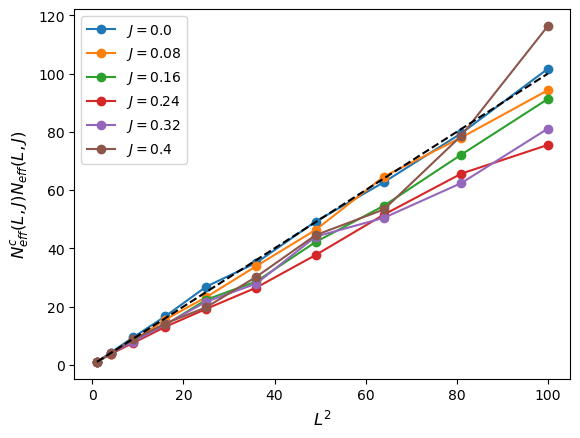

In [568]:
for j,J in enumerate(J_arr):
    plt.plot(L_arr**2,Nc_eff[:,j]*Neff_arr[:,j],'-o',label=f'$J={np.round(J,2)}$')

plt.plot(np.linspace(L_arr[0]**2,L_arr[-1]**2),np.linspace(L_arr[0]**2,L_arr[-1]**2),'k--')
plt.xlabel(r'$L^2$',size=12)
plt.ylabel(r'$N^c_{eff}(L,J) N_{eff}(L,J)$',size=12)
plt.legend()
plt.show()

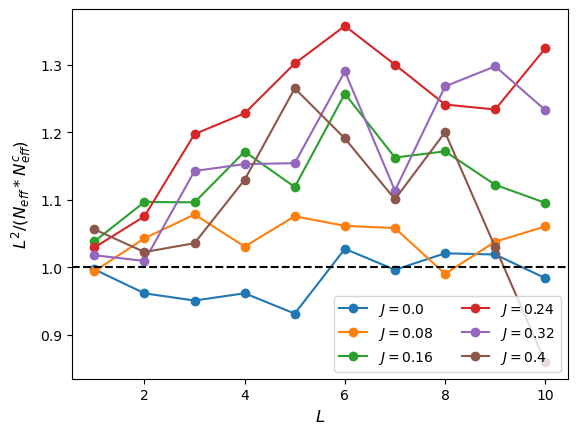

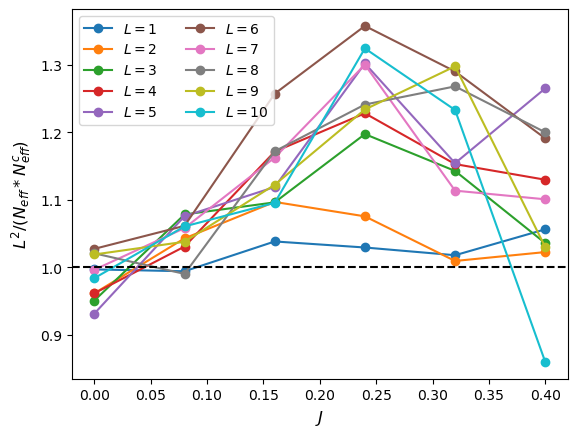

In [569]:
for j,J in enumerate(J_arr):
    plt.plot(L_arr,L_arr**2/(Neff_arr[:,j]*Nc_eff[:,j]),'-o',label=f'$J={np.round(J,2)}$')

plt.axhline(1,color='k',linestyle='--')
plt.xlabel(r'$L$',size=12)
plt.ylabel(r'$L^2/(N_{eff}*N^c_{eff})$',size=12)
plt.legend(ncol=2)
plt.show()

for l,L in enumerate(L_arr):
    plt.plot(J_arr,L**2/(Neff_arr[l,:]*Nc_eff[l,:]),'-o',label=f'$L={L}$')

plt.axhline(1,color='k',linestyle='--')
plt.xlabel(r'$J$',size=12)
plt.ylabel(r'$L^2/(N_{eff}*N^c_{eff})$',size=12)
plt.legend(ncol=2)
plt.show()

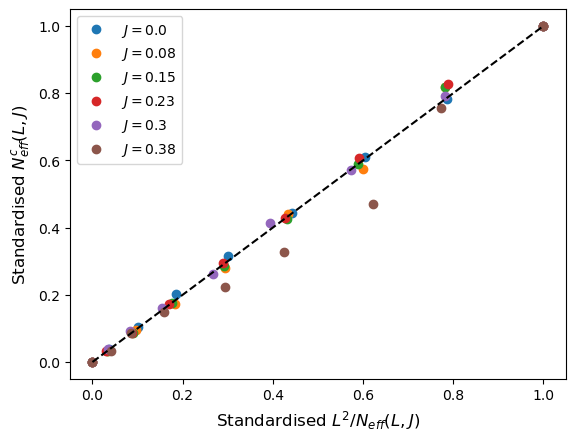

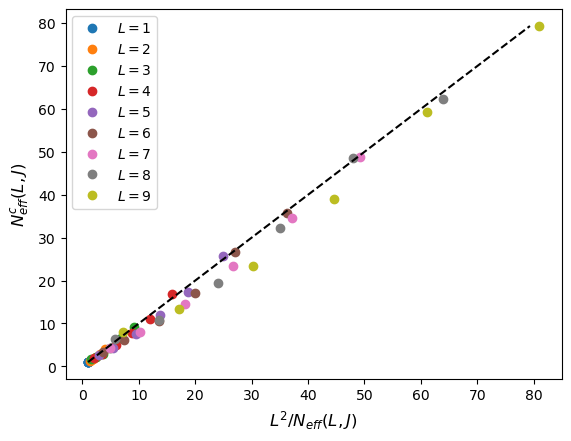

In [560]:
for j,J in enumerate(J_arr):
    stan_L2_Neff = (L_arr**2/Neff_arr[:,j] - np.min(L_arr**2/Neff_arr[:,j]))/(np.max(L_arr**2/Neff_arr[:,j])-np.min(L_arr**2/Neff_arr[:,j]))
    stan_Nceff = (Nc_eff[:,j] - np.min(Nc_eff[:,j]))/(np.max(Nc_eff[:,j]) - np.min(Nc_eff[:,j]))
    plt.plot(stan_L2_Neff,stan_Nceff,'o',label=f'$J={np.round(J,2)}$')

plt.plot(np.linspace(0,1),np.linspace(0,1),'k--')
plt.xlabel(r'Standardised $L^2/N_{eff}(L,J)$',size=12)
plt.ylabel(r'Standardised $N^c_{eff}(L,J)$',size=12)
plt.legend()
plt.show()

for l,L in enumerate(L_arr):
    plt.plot(L**2/Neff_arr[l,:],Nc_eff[l,:],'o',label=f'$L={L}$')

plt.plot(np.linspace(np.min(Nc_eff),np.max(Nc_eff)),np.linspace(np.min(Nc_eff),np.max(Nc_eff)),'k--')
plt.xlabel(r'$L^2/N_{eff}(L,J)$',size=12)
plt.ylabel(r'$N^c_{eff}(L,J)$',size=12)
plt.legend()
plt.show()

### Alternative, slower implementations

In [29]:
@numba.jit(nopython=True)
def original_ising_rates(s,J,H,omega0=1,open_boundary=True):
    # roll the states to find the nearest neighbours for each spin
    left = np.empty(s.shape)
    right = np.empty(s.shape)
    top = np.empty(s.shape)
    bottom = np.empty(s.shape)

    # roll the states (in the dumb numba way)
    for i in range(s.shape[0]):
        left[i,:] = np.roll(s[i,:],1)
        right[i,:] = np.roll(s[i,:],-1)
        top[:,i] = np.roll(s[:,i],1)
        bottom[:,i] = np.roll(s[:,i],-1)
        
    # if have open boundaries, remove neighbours at the edges
    if open_boundary:
        # remove boundary neighbours
        left[:,0] = 0.
        right[:,-1] = 0.
        top[0,:] = 0.
        bottom[-1,:] = 0.
    
    # compute the energy contributions
    coupling = J*s*(left+right+top+bottom) # coupling energy
    external = H*s # external-field energy
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(coupling+external))

In [30]:
@numba.jit(nopython=True)
def loop_ising_rates(s,J,H,omega0=1,open_boundary=True):
    # arrays to store the nearest neighbours
    left = np.empty_like(s)
    right = np.empty_like(s)
    top = np.empty_like(s)
    bottom = np.empty_like(s)

    # loop through the array to store nearest neighbours (fast than using np.roll in Numba)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            left[i,j] = s[i,j-1]
            right[i,j] = s[i,(j+1)%s.shape[1]]
            top[i,j] = s[i-1,j]
            bottom[i,j] = s[(i+1)%s.shape[0],j]
                    
    # if have open boundaries, remove neighbours at the edges
    if open_boundary:
        left[:,0] = 0.
        right[:,-1] = 0.
        top[0,:] = 0.
        bottom[-1,:] = 0.
    
    # compute the energy contributions
    coupling = J*s*(left+right+top+bottom) # coupling energy
    external = H*s # external-field energy
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(coupling+external))

In [31]:
@numba.jit(nopython=True)
def open_ising_rates(s,J,H,omega0=1,open_boundary=True):
    # arrays to store the nearest neighbours
    nn = np.empty_like(s)

    # loop through the array to store nearest neighbours (fast than using np.roll in Numba)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            if j == 0:
                left = 0
            elif j == s.shape[1] - 1:
                right = 0
            else:
                left = s[i,j-1]
                right = s[i,(j+1)%s.shape[1]]
            if i == 0:
                top = 0
            elif i == s.shape[0] - 1:
                bottom = 0
            else:
                top = s[i-1,j]
                bottom = s[(i+1)%s.shape[0],j]
            
            nn[i,j] = left + right + top + bottom
                    
    # if have periodic boundaries, add neighbours at the edges
    if open_boundary == False:
        nn[:,0] += s[:,-1]
        nn[:,-1] += s[:,0]
        nn[0,:] += s[-1,:]
        nn[-1,:] += s[0,:]
    
    # compute the energy contributions
    coupling = J*s*nn # coupling energy
    external = H*s # external-field energy
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(coupling+external))

In [32]:
J = 1
H = 1
s = np.random.choice([-1.,1.],size=(50,50))

%timeit original_ising_rates(s,J,H)
%timeit loop_ising_rates(s,J,H)
%timeit open_ising_rates(s,J,H)
%timeit ising_rates(s,J,H)

191 µs ± 61 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
121 µs ± 42 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 µs ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
122 µs ± 43.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Adaptive Ising Model

In [33]:
@numba.jit(nopython=True)
def demethylation_rates(s,m,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(m,dtype='float64')
    meth_rates = np.zeros_like(m,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            # demethylation
            if s[i,j] == 1 and m[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if s[i,j] == -1 and m[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [34]:
s = np.random.choice([-1.,1.],size=(50,50))
m = np.random.choice(np.arange(0,5),size=(50,50))
kR = 1
kB = 2

%timeit demethylation_rates(s,m,kR,kB)

4.61 µs ± 9.96 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [35]:
@numba.jit(nopython=True)
def adaptive_ising_simulator(Ns,tf,tc,L,J,
                    omega0=1,c0=100,cf=90,Ki=18,Ka=2900,dfm=-2,m0=0.5,kR=0.01,kB=0.02):
    '''
    Simulates a kinetic, non-adaptive two-dimensional Ising model on a square lattice 
    using Gillespie's algorithm. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of realisations
    tf: float
        final time of the simulation
    tc: float
        time at which the concentration changes
    L: int
        linear dimension of lattice, i.e., there are LxL spins
    J: float
        coupling strength in units of kBT
    omega0: float, optional
        fundamental flipping frequency. Note that all time is in units of 1/omega0
    c0: float, optional
        baseline concentration. Default is 100 microM
    cf: float, optional
        concentration after the step change Default is 90 microM
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively.
    dfm: float
        free-energy cost of an additional methyl group. Default is -2 kT
    m0: float
        baseline methylation level. Default is 0.5
    kR, kB: float
        methylation and demethylation rate, respectively. Defaults are 0.01 omega0
        and 0.02 omega0, respectively
        
    Returns
    ---------
    s_ensemble: typed List
        contains the ensemble of Ns realisations of the Ising model's spins
        note: ensemble[0] gives the first realisation; ensemble[0][0] the first lattice of
        the first realisation etc.
    m_ensemble: typed List
        contains the ensemble of Ns realisations of the Ising model's methylation level
        note: the shape is the same as for s_ensemble and methylation level is NOT normalised
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    '''
    # Numba lists to store results
    s_ensemble = List()
    m_ensemble = List()
    all_tau = List()

    # obtain Ns realisations
    for n in range(Ns):
        # initialise each realisation
        s = biased_choice(np.array([-1.,1.]),np.array([kB/(kR+kB),kR/(kR+kB)]),size=L**2).reshape((L,L)) # spins
        spins = np.expand_dims(s,axis=0)

        m = biased_choice(np.array([1.,2.]),np.array([0.92,0.08]),size=L**2).reshape((L,L)) # methylation level

        #m = biased_choice(np.linspace(0,4,5),np.linspace(0,4,5)[::-1]/np.sum(np.linspace(0,4,5)),
        #                   size=L**2).reshape((L,L)) # methylation level
        meth = np.expand_dims(m,axis=0)

        tau = np.zeros(1,dtype='float64') # waiting time and time counter
        time = 0

        H = -0.5*np.log((1+c0/Ki)/(1+c0/Ka))-0.5*dfm*(m-m0) # initial external field
        switch_bool = False # to check whether concentration has changed

        # evolve system until tf
        while time <= tf:
            # determine the various rates
            flipping_rates = ising_rates(s,J,H,omega0=omega0)
            demeth_rates, meth_rates = demethylation_rates(s,m,kR,kB)
            Omega = np.sum(flipping_rates + demeth_rates + meth_rates)

            # sample time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/Omega

            # if has passed tc: reset the system to the time of the concentration change
            if time > tc and switch_bool == False:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/Omega)

                # update external field and rates
                H = -0.5*np.log((1+cf/Ki)/(1+cf/Ka))-0.5*dfm*(m-m0)
                flipping_rates = ising_rates(s,J,H,omega0=omega0) # only flipping rates change
                Omega = np.sum(flipping_rates + demeth_rates + meth_rates)

                # sample time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/Omega
                tau = np.append(tau,advance-np.log(u)/Omega)

                # update the boolean to prevent further switching
                switch_bool = True

            else: # most cases; just append time and continue
                tau = np.append(tau,-np.log(u)/Omega)

            # determine which event occurs
            flat_rates = np.concatenate((flipping_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                         meth_rates.reshape(L**2))) # useful to have a 1-dim 3L^2 array
            p = np.random.uniform(0,1)*Omega
            e_idx = np.argmax(p < np.cumsum(flat_rates))

            # obtain the type of event and coordinate
            e_type, coord = np.divmod(e_idx,L**2)
            x,y = np.divmod(coord,L)

            # perform event based on what type of event occurred
            if e_type == 0: # spin flip
                s[x,y] *= -1.
            elif e_type == 1: # demethylation
                m[x,y] += -1.
                H[x,y] += 0.5*dfm # update external field
            else: # methylation
                m[x,y] += 1.
                H[x,y] += -0.5*dfm # update external field

            # save state
            spins = np.concatenate((spins,np.expand_dims(s,axis=0)))
            meth = np.concatenate((meth,np.expand_dims(m,axis=0)))

        s_ensemble.append(spins)
        m_ensemble.append(meth)
        all_tau.append(tau)
        
    return s_ensemble, m_ensemble, all_tau

In [36]:
Ns = 100
tf = 30
tc = 15
L = 2
J = 0.3

%timeit adaptive_ising_simulator(Ns,tf,tc,L,J)

22.5 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
Ns = 5000
tf = 150
tc = 75
L = 2
J = 0.
kR = 0.1
kB = 0.2

s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=70,kR=kR,kB=kB)

In [38]:
st = 0.01
s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
m_samples, t_grid = ising_sampler(m_ensemble,all_tau,Ns,tf,st)

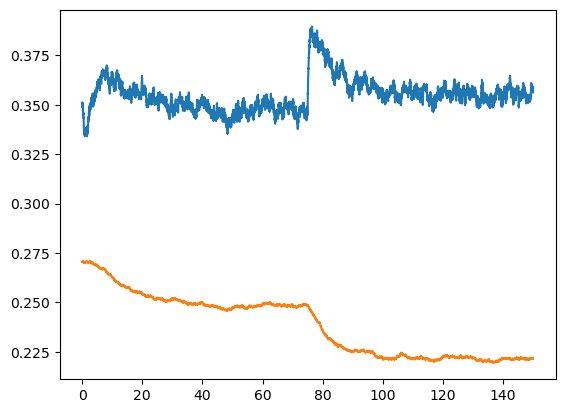

In [39]:
spin = np.mean(s_samples,axis=(0,-1,-2))
meth_level = np.mean(m_samples,axis=(0,-1,-2))/4
plt.plot(t_grid,0.5*(spin+1))
plt.plot(t_grid,meth_level)
plt.show()